# Exercises

In [1102]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

### Data preparation

To better organize the workflow and manage the numerous datasets in this notebook, we have created a loop that iterates through the datasets stored in the folder assigned to our group. It loads each dataset into a DataFrame object and stores them in a list of DataFrames. This allows us to iterate over the list if we want to perform operations on all 10 datasets, avoiding the need to read the datasets repeatedly.

In [1103]:
# List to hold all DataFrames
dataframes = []

# Iterate over files in the directory
for f in os.listdir('./ProjectDatasets/Team_7'):
    if f.endswith('.csv'):  # Check if it's a CSV file
        df = pd.read_csv(os.path.join('./ProjectDatasets/Team_7', f))
        df['Company'] = os.path.splitext(f)[0]  # Add a Company column using the filename (without extension)
        # Ensure the 'Date' column is parsed as datetime
        df['Date'] = pd.to_datetime(df['Date'])
        dataframes.append(df)

We define the columns that are numerical and relative to the stock price, so we can call this list when we need it to iterate through these columns to make transformations.

In [1104]:
num_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

We have also created a single combined DataFrame in case it proves useful for any exercise.

In [1105]:
merged_df = pd.concat(dataframes, ignore_index=True)
columns = ['Company'] + [col for col in merged_df.columns if col != 'Company']
dfm = merged_df[columns]

#### Data Observation

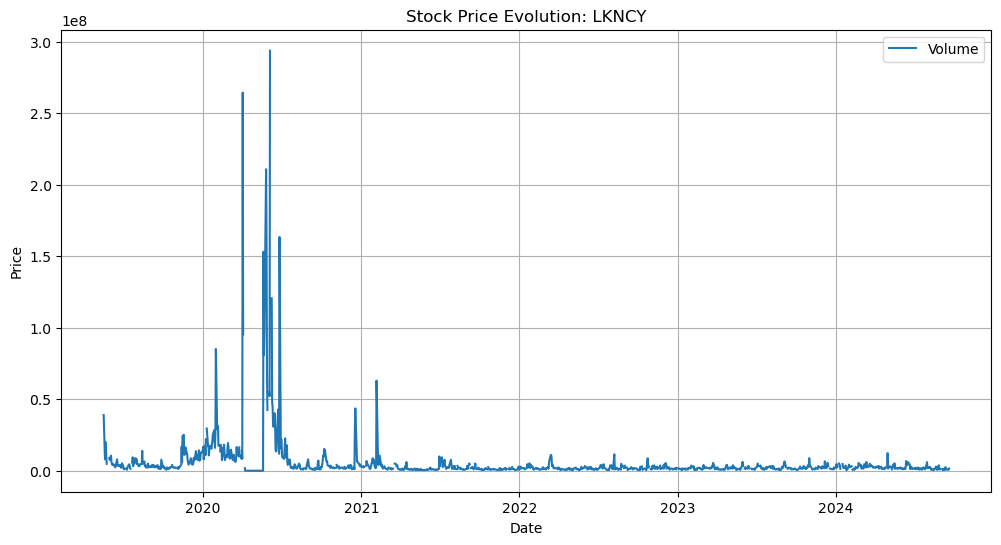

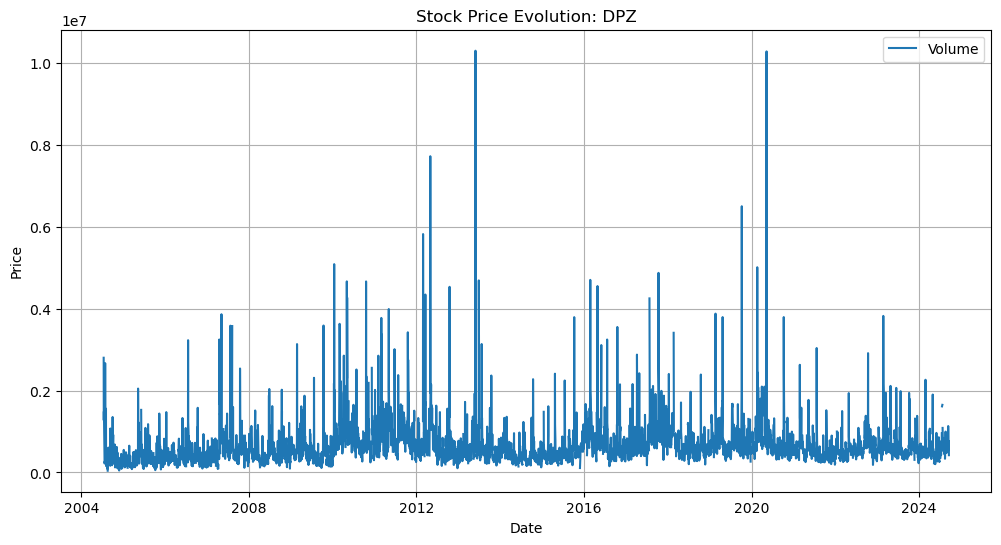

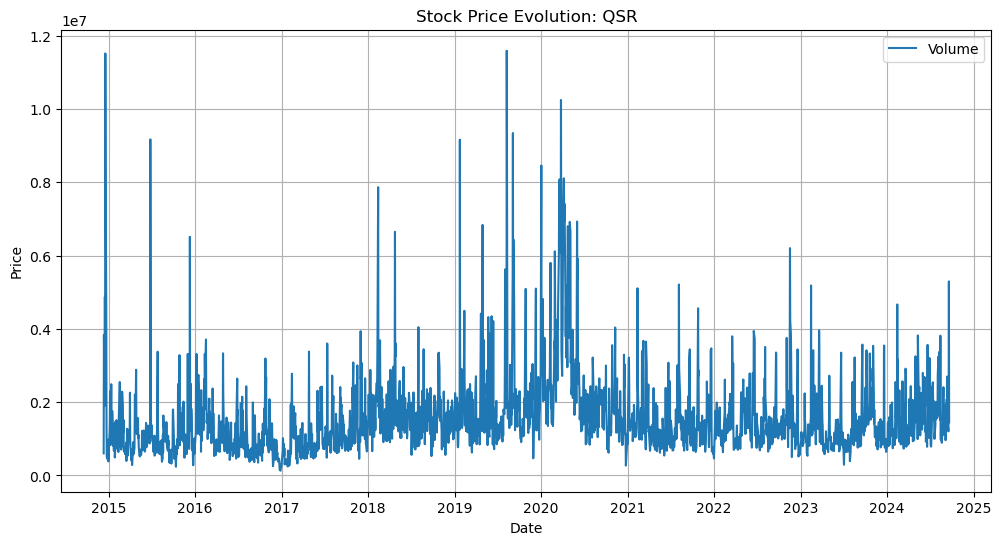

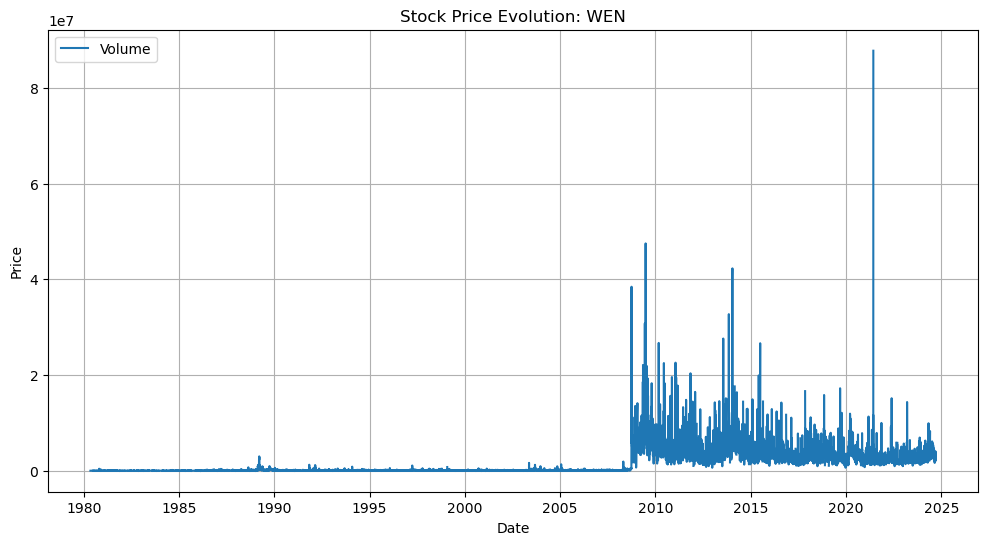

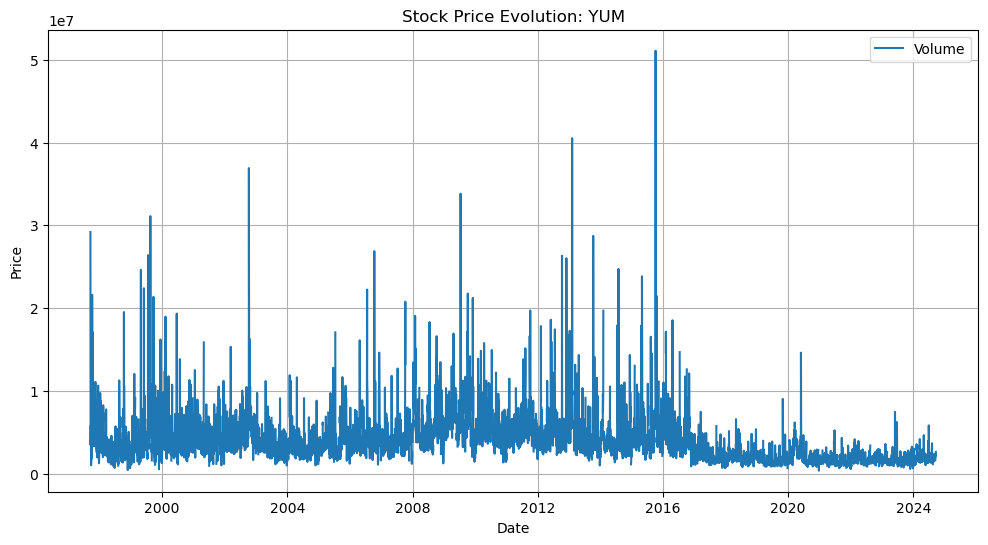

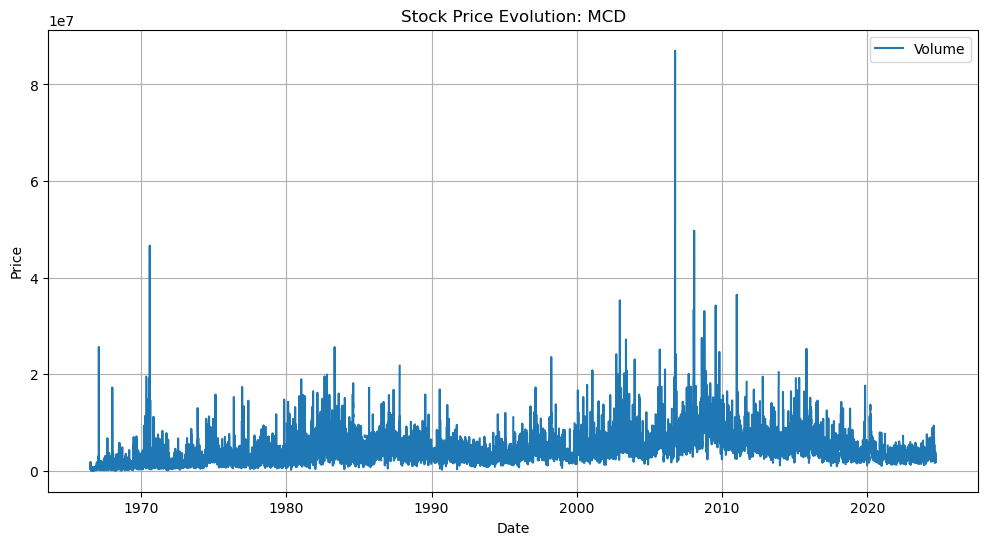

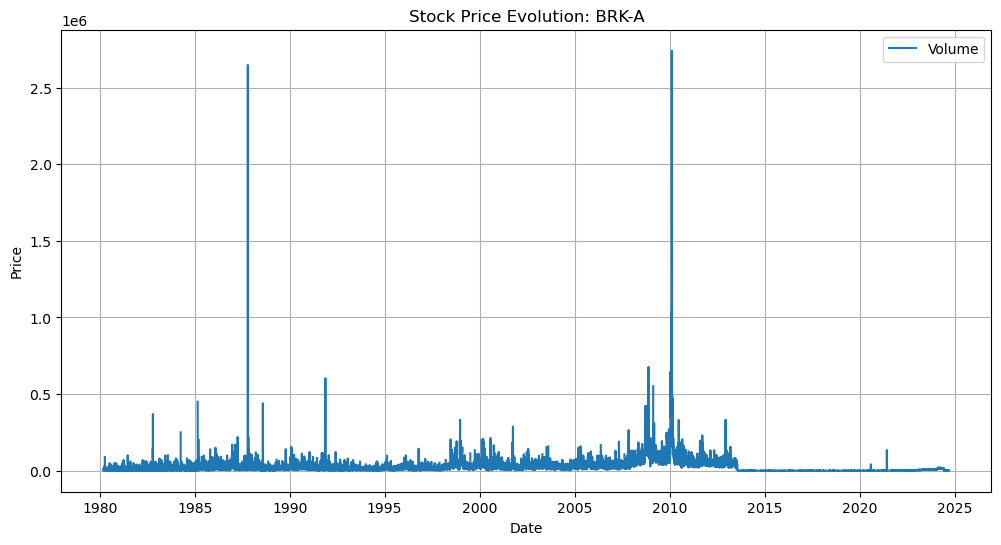

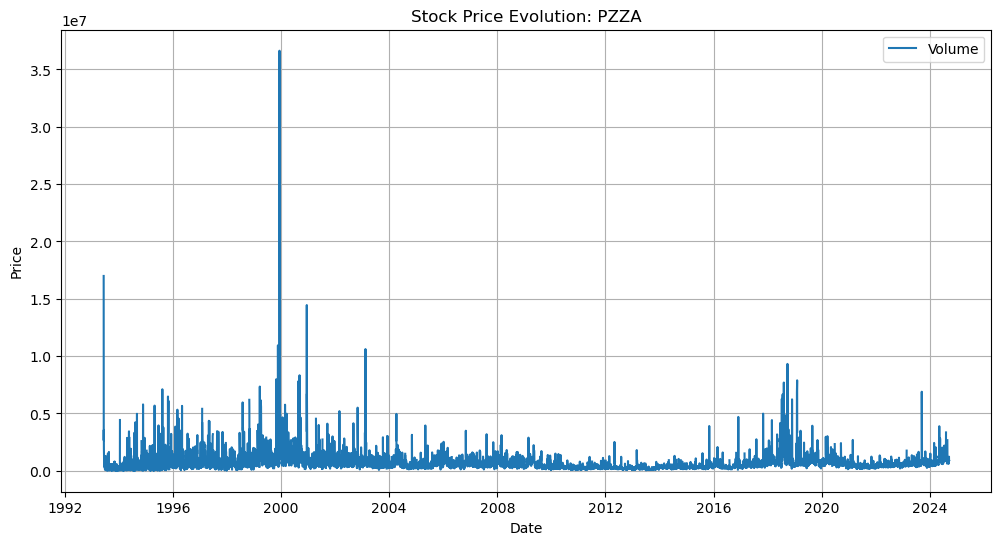

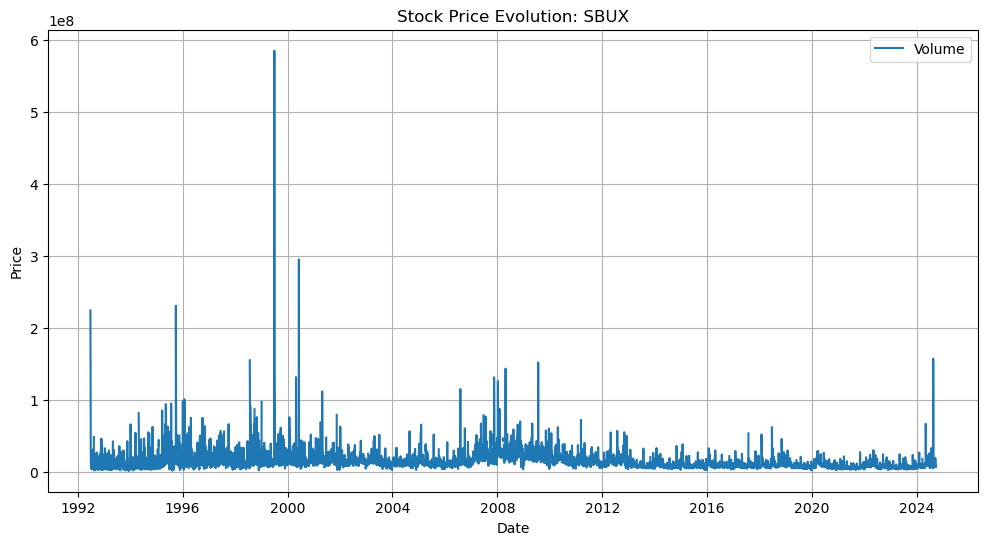

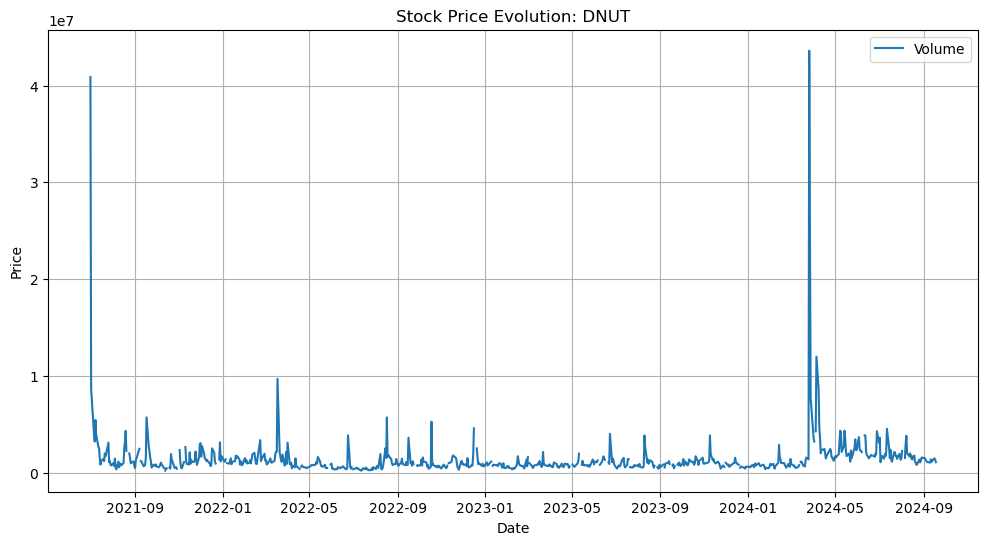

In [1106]:
for df in dataframes:
    # Ensure the 'Date' column is parsed as datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the data by date for proper plotting
    df.sort_values('Date', inplace=True)
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Volume'], label='Volume')
        
    # Chart formatting
    plt.title(f"Stock Price Evolution: {df["Company"][0]}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

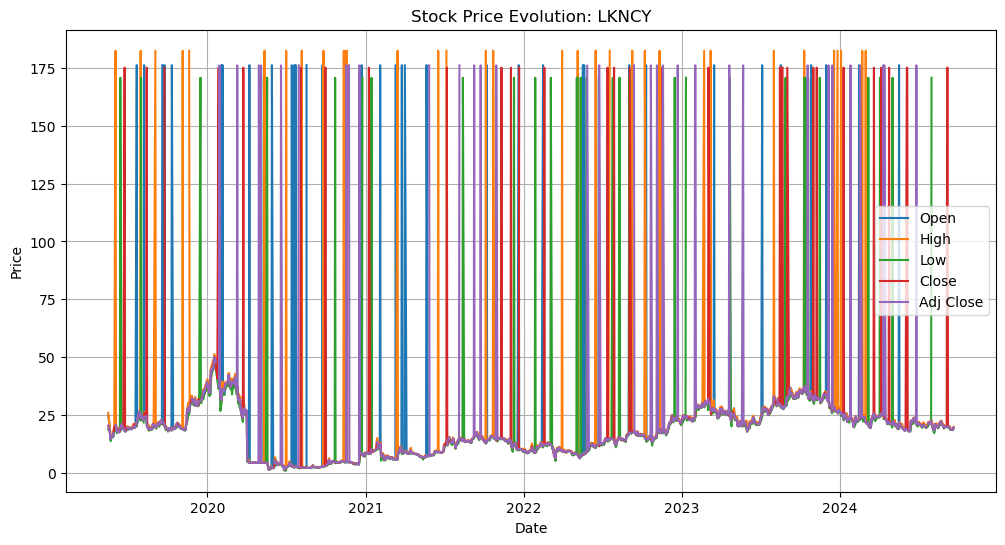

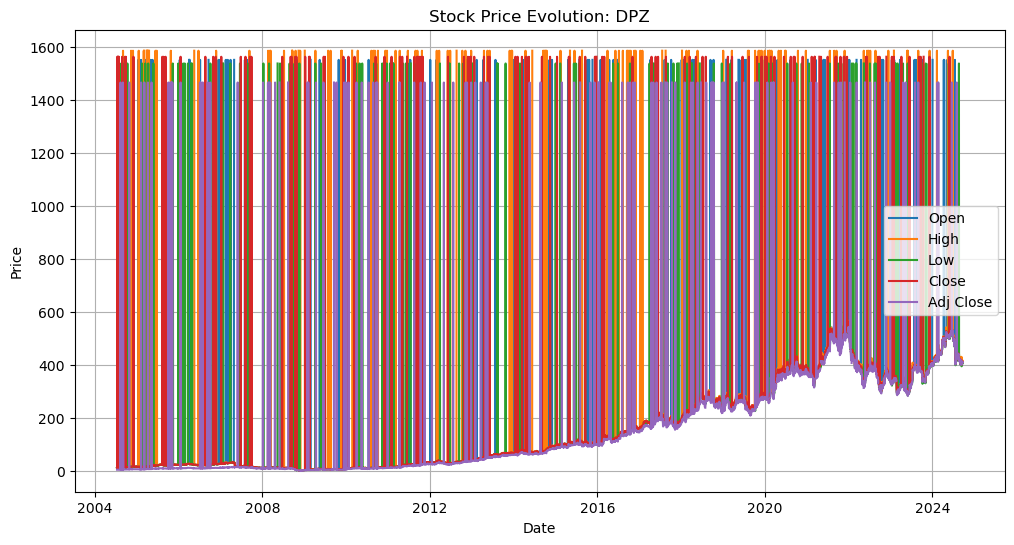

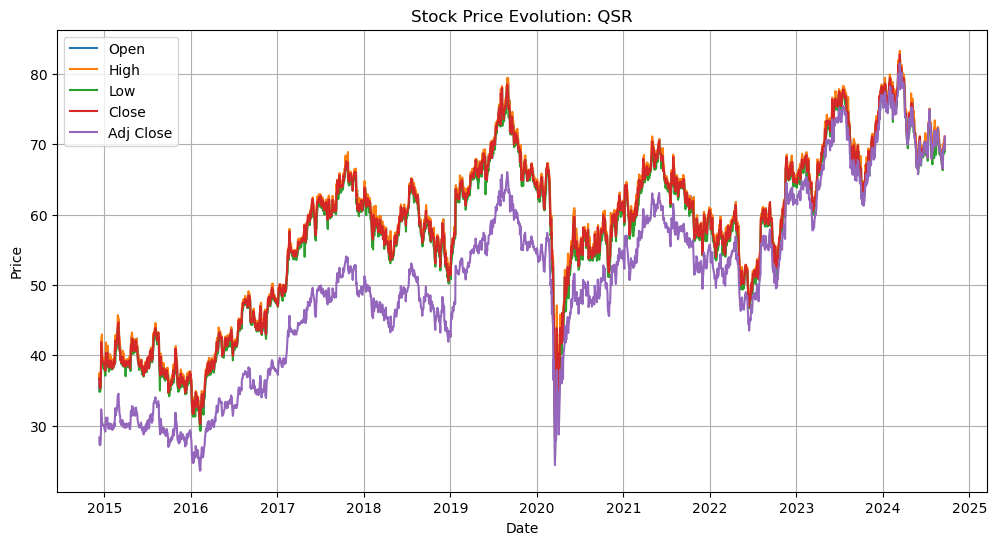

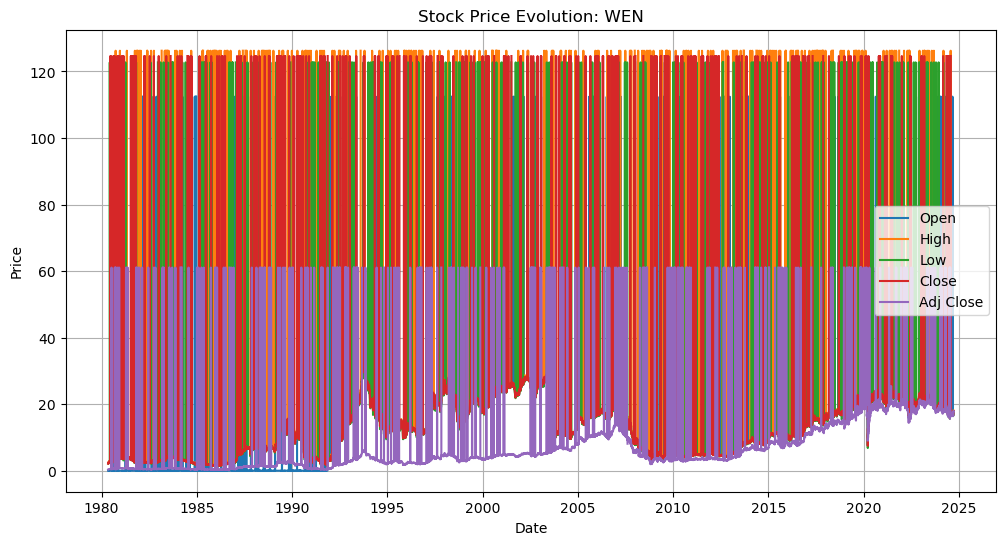

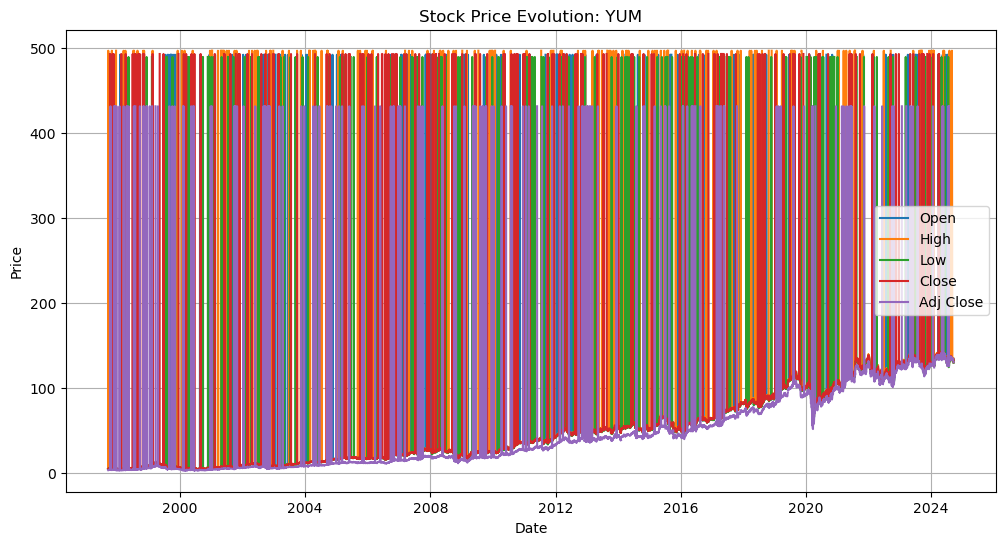

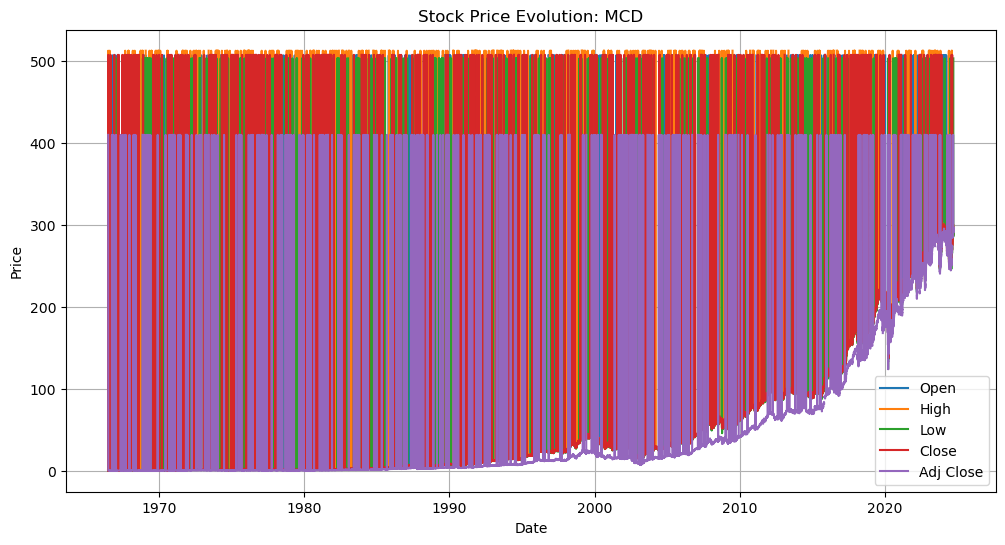

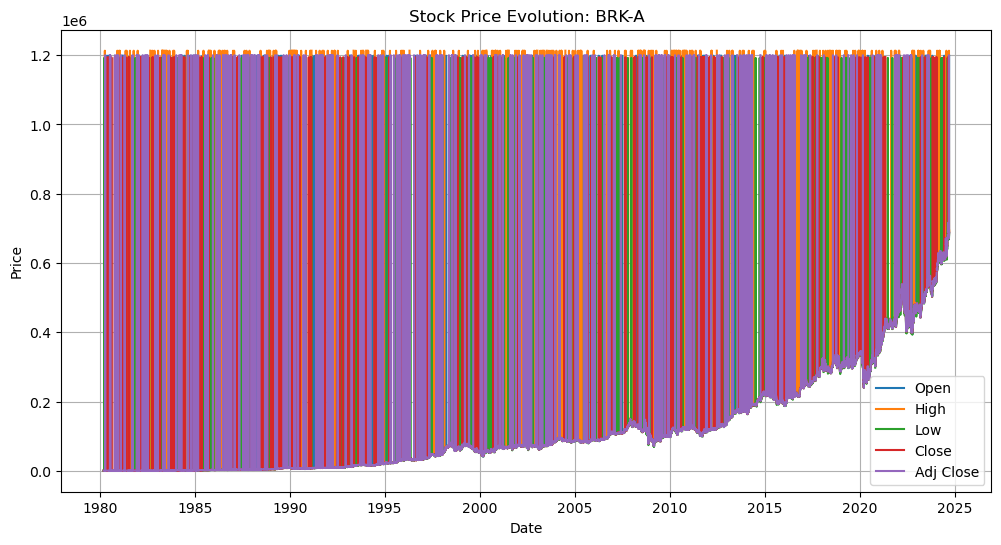

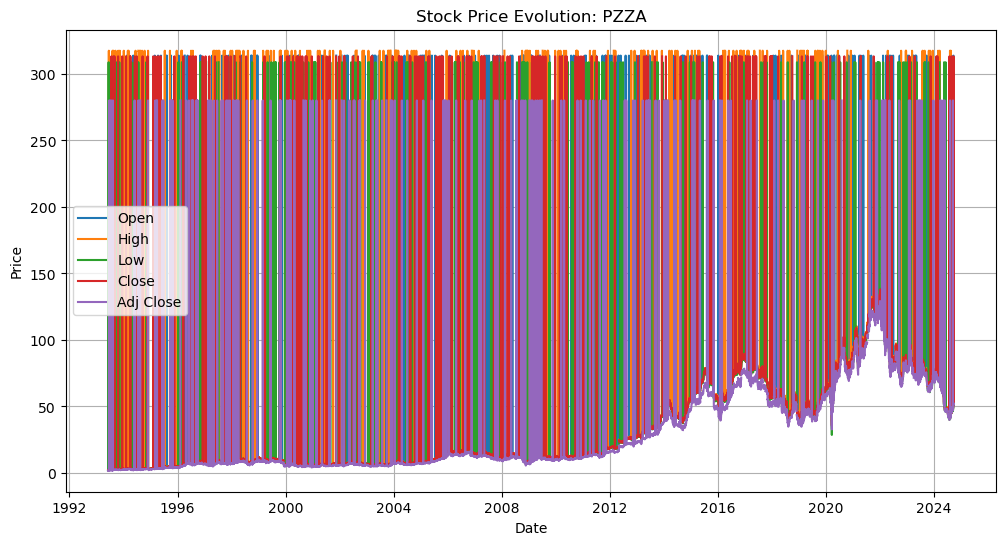

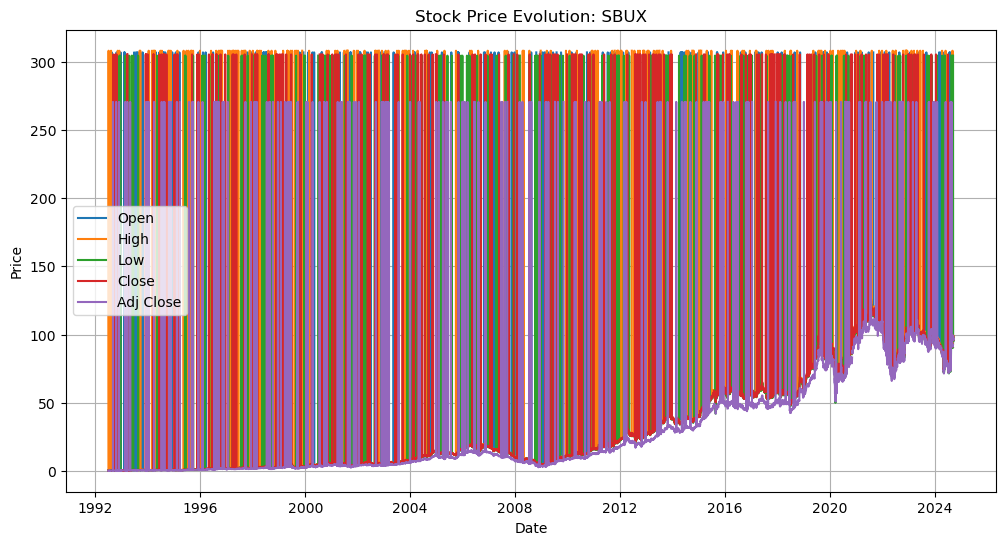

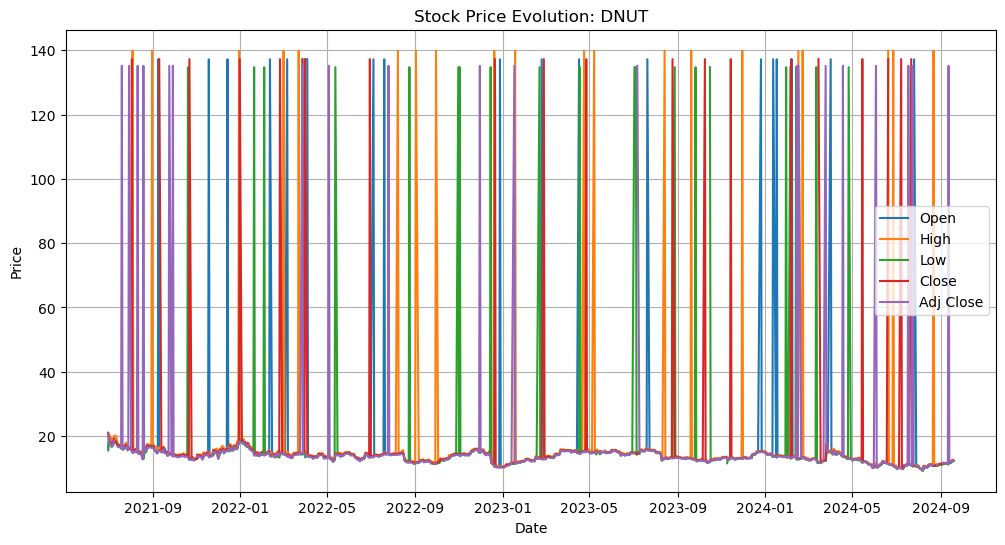

In [1107]:
for df in dataframes:
    # Ensure the 'Date' column is parsed as datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the data by date for proper plotting
    df.sort_values('Date', inplace=True)
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    for variable in num_columns[:-1]:
        plt.plot(df["Date"], df[variable], label=variable)
    
    # Chart formatting
    plt.title(f"Stock Price Evolution: {df["Company"][0]}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Missing data

In [1108]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

Company  Date  Open  High   Low  Close  Adj Close  Volume
LKNCY      0.0   0.0  4.81  4.96  4.89   4.67       4.89    4.96
DPZ        0.0   0.0  4.83  4.87  4.89   4.87       4.91    4.99
QSR        0.0   0.0  0.00  0.00  0.00   0.00       0.00    0.00
WEN        0.0   0.0  4.89  4.83  4.86   4.91       4.88    4.99
YUM        0.0   0.0  4.90  4.87  4.88   4.94       4.87    5.01
MCD        0.0   0.0  4.90  4.88  4.89   4.81       4.89    5.00
BRK-A      0.0   0.0  4.89  4.85  4.93   4.87       4.85    5.00
PZZA       0.0   0.0  4.76  4.83  4.88   4.90       4.86    5.00
SBUX       0.0   0.0  4.85  4.84  4.88   4.95       4.88    5.00
DNUT       0.0   0.0  5.03  4.79  4.91   4.79       4.91    4.91

As we can observe, there are around 5% missing observations for each variable in each company, except for the company QSR, which has no missing data.

#### Manually manipulated data ranges

With the help of the visualizations above, we identified some manually manipulated ranges of data, where the scale for Volume variable was clearly changed applying what we think is probably a multiplier. In the case of WEN, apart from the Volume, we think the Open Price variable was also manipulated setting to 0 the first values.

In [1109]:
# # Find the index where the 'Open' values stop being 0
# first_no_zero = dataframes[3][dataframes[3]['Open'] != 0].index[0]

# # Replace 'Open' values that are 0 with the corresponding 'Close' values
# dataframes[3].loc[:first_no_zero - 1, "Open"] = dataframes[3].loc[:first_no_zero - 1, "Close"]

In [1110]:
# Obtener el índice hasta donde la columna 'Open' tiene valor 0
zero_indices = dataframes[3][dataframes[3]['Open'] == 0].index

# Si hay índices encontrados, modificar la columna 'Open'
if not zero_indices.empty:
    max_index = zero_indices[-1]
    dataframes[3].loc[:max_index, 'Open'] = dataframes[3].loc[:max_index, 'Close']


In [1111]:
window_size = 3
threshold = 0.80

change_range_df = dataframes[6][(dataframes[6]["Date"].dt.year > 2011) & (dataframes[6]["Date"].dt.year <= 2013)]

rolling_mean = change_range_df["Volume"].rolling(window=window_size, center=True).mean()


# rolling_mean = rolling_mean.fillna(method='bfill').fillna(method='ffill')

relative_change = abs(change_range_df["Volume"] - rolling_mean) / rolling_mean
change_scaling_index = relative_change.sort_values(ascending=False).index[0]

# Calculate the proportion
former_scale = dataframes[6].loc[change_scaling_index-3:change_scaling_index-1]["Volume"].mean()
new_scale = dataframes[6].loc[change_scaling_index:change_scaling_index+2]["Volume"].mean()
proportion = former_scale / new_scale

# Apply the scaling to the "Volume" column from index 8416 onward
dataframes[6].loc[change_scaling_index:, "Volume"] = dataframes[6].loc[change_scaling_index:, "Volume"].apply(lambda x: x * proportion)


In [1112]:
dataframes[3].loc[7166-3:7166+3]

Date  Open  High   Low  Close  Adj Close      Volume Company
7163 2008-09-24  5.01  5.23  5.01   5.12   3.526668    366600.0     WEN
7164 2008-09-25  5.25  5.29  5.15   5.24   3.609323    601100.0     WEN
7165 2008-09-26  5.11  5.43  5.04   5.43   3.740193    410700.0     WEN
7166 2008-09-29  5.43  6.90  4.10   5.90        NaN  38457700.0     WEN
7167 2008-09-30  5.40  5.85   NaN   5.26   3.623099  10110600.0     WEN
7168 2008-10-01  5.23  5.30  4.80   4.97   3.423346   6187800.0     WEN
7169 2008-10-02  5.10  5.10  4.67   4.71   3.244257   5735000.0     WEN

In [1113]:
window_size = 3
threshold = 0.80

change_range_df = dataframes[3][(dataframes[3]["Date"].dt.year >= 2007) & (dataframes[3]["Date"].dt.year <= 2010)]

rolling_mean = change_range_df["Volume"].rolling(window=window_size, center=True).mean()


# rolling_mean = rolling_mean.fillna(method='bfill').fillna(method='ffill')

relative_change = abs(change_range_df["Volume"] - rolling_mean) / rolling_mean
change_scaling_index = relative_change.sort_values(ascending=False).index[0]

# Calculate the proportion
former_scale = dataframes[3].loc[change_scaling_index-3:change_scaling_index-1]["Volume"].mean()
new_scale = dataframes[3].loc[change_scaling_index:change_scaling_index+2]["Volume"].mean()
proportion = former_scale / new_scale

# Apply the scaling to the "Volume" column from index 8416 onward
dataframes[3].loc[change_scaling_index:, "Volume"] = dataframes[3].loc[change_scaling_index:, "Volume"].apply(lambda x: x * proportion)


In [1114]:
change_scaling_index

7166

In [1115]:
proportion

0.025173450994501072

In [1116]:
dataframes[6]

Date          Open          High       Low     Close  \
0     1980-03-17  2.900000e+02  3.100000e+02     290.0     290.0   
1     1980-03-18  2.900000e+02  2.900000e+02     290.0     290.0   
2     1980-03-19           NaN  3.100000e+02       NaN     290.0   
3     1980-03-20  2.900000e+02  2.900000e+02     290.0     290.0   
4     1980-03-21  2.900000e+02  2.900000e+02     290.0     290.0   
...          ...           ...           ...       ...       ...   
11217 2024-09-13  6.773520e+05  6.782340e+05  671000.0  671750.0   
11218 2024-09-16  6.730380e+05  1.212696e+06  671436.0  677731.0   
11219 2024-09-17  6.807030e+05  6.911640e+05  679124.0  685250.0   
11220 2024-09-18  6.875000e+05  6.889020e+05  682214.0  686859.0   
11221 2024-09-19  1.198210e+06  6.937750e+05  686000.0  687840.0   

          Adj Close    Volume Company  
0      2.900000e+02   10000.0   BRK-A  
1      2.900000e+02       0.0   BRK-A  
2      2.900000e+02   20000.0   BRK-A  
3      2.900000e+02       0.0   BRK-A  
4      2.900000e+02       0.0   BRK-A  
...             ...       ...     ...  
11217  6.717500e+05  193420.0   BRK-A  
11218  1.199727e+06  193420.0   BRK-A  
11219  6.852500e+05  132340.0   BRK-A  
11220  6.868590e+05  122160.0   BRK-A  
11221           NaN  152700.0   BRK-A  

[11227 rows x 8 columns]

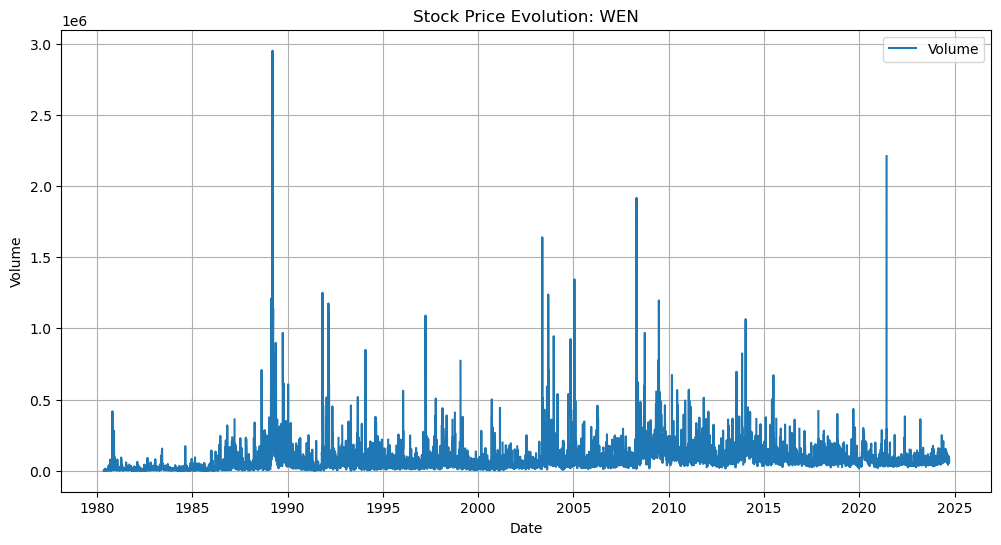

In [1117]:
# Ensure the 'Date' column is parsed as datetime
dataframes[3]['Date'] = pd.to_datetime(dataframes[3]['Date'])

# Sort the data by date for proper plotting
dataframes[3].sort_values('Date', inplace=True)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(dataframes[3]['Date'], dataframes[3]['Volume'], label='Volume')
    
# Chart formatting
plt.title(f"Stock Price Evolution: {dataframes[3]["Company"][0]}")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

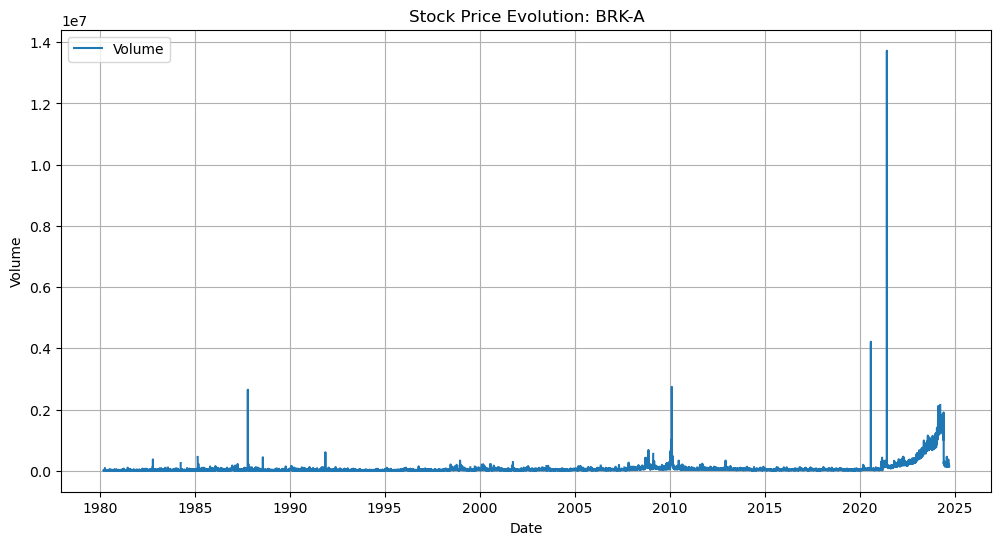

In [1118]:
# Ensure the 'Date' column is parsed as datetime
dataframes[6]['Date'] = pd.to_datetime(dataframes[6]['Date'])

# Sort the data by date for proper plotting
dataframes[6].sort_values('Date', inplace=True)

# Plot the line chart
plt.figure(figsize=(12, 6))
plt.plot(dataframes[6]['Date'], dataframes[6]['Volume'], label='Volume')
    
# Chart formatting
plt.title(f"Stock Price Evolution: {dataframes[6]["Company"][0]}")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

In [1119]:
# # Calculate percentage change
# dataframes[6]["Volume_Change"] = dataframes[6]["Volume"].pct_change()

# # Filter out infinity values and find the index of the max value
# max_change_index = dataframes[6][dataframes[6]["Volume_Change"] != float('inf')]["Volume_Change"].idxmax()

# print(f"The index with the highest percentage change (excluding infinity) is: {max_change_index}")


#### Outliers

First, we need to identify whether there are outliers in the datasets and how they are distributed. To do this, we use boxplots for each variable and each company.

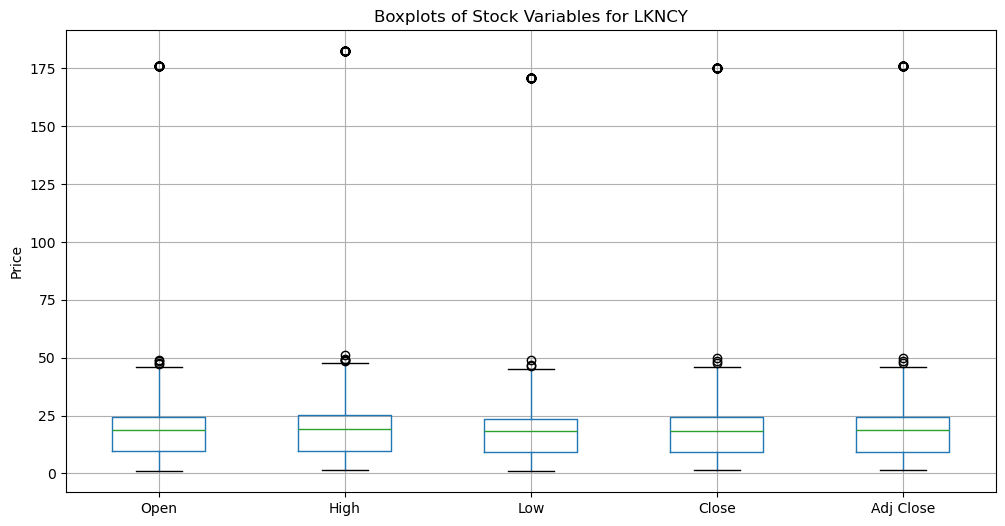

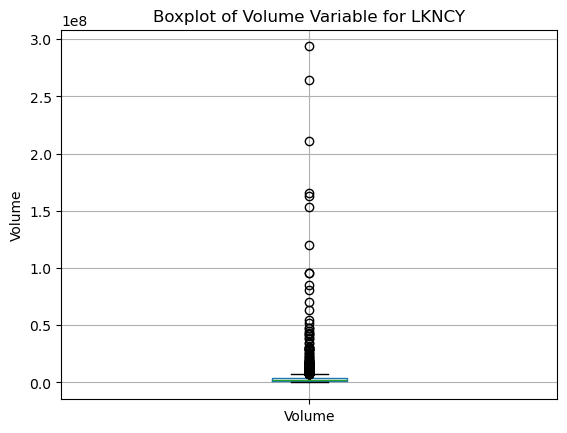

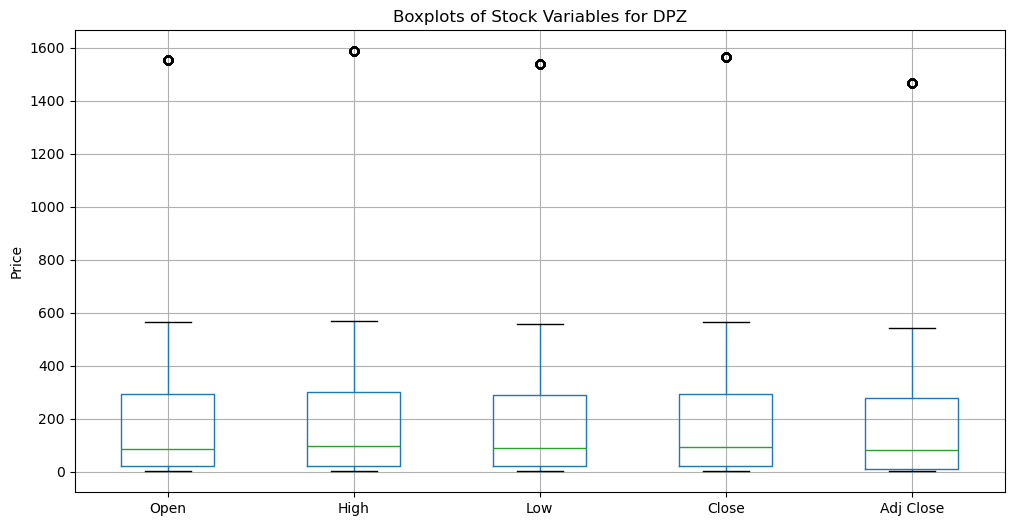

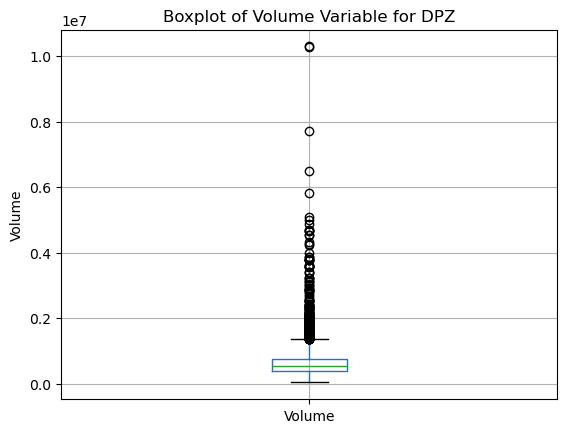

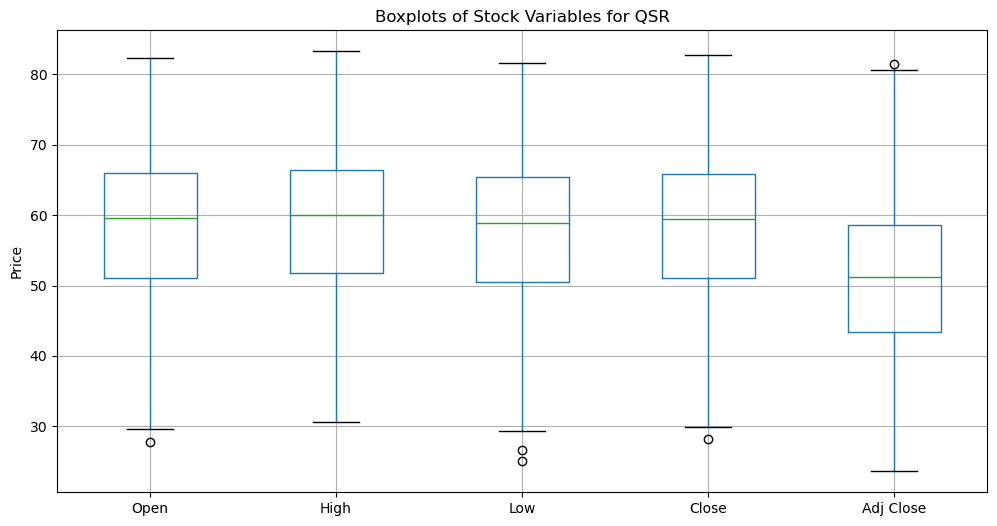

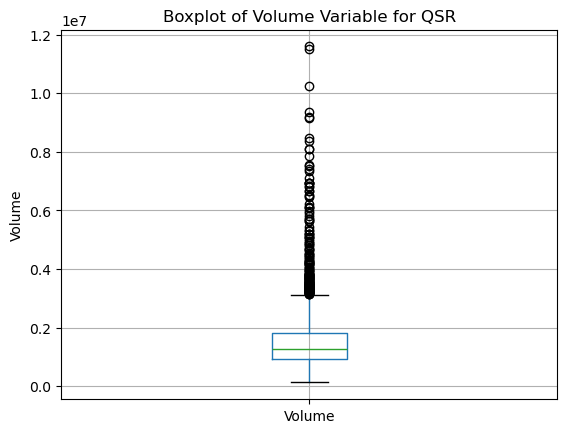

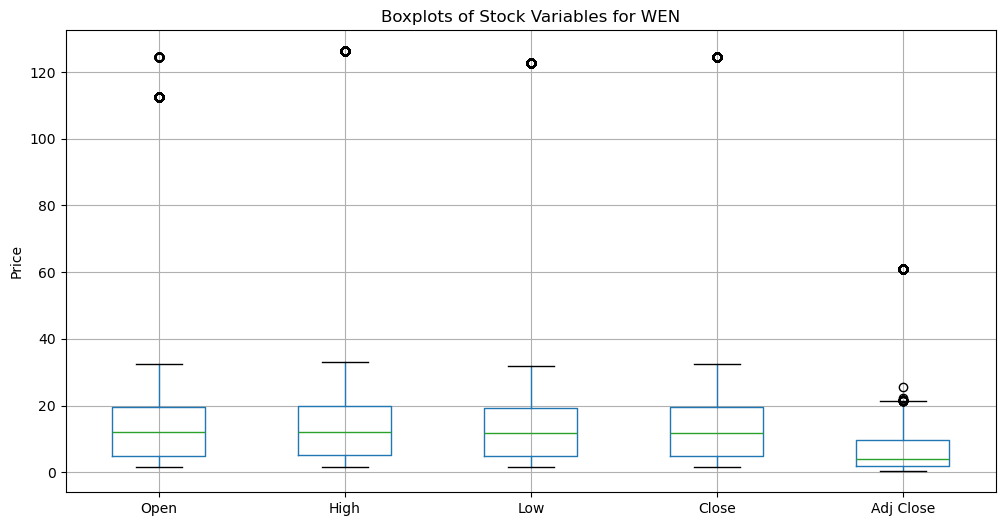

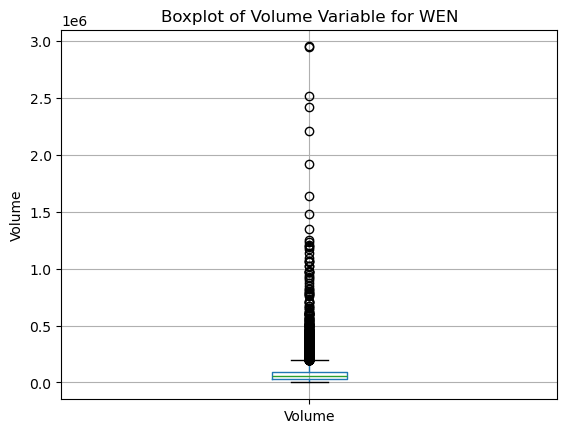

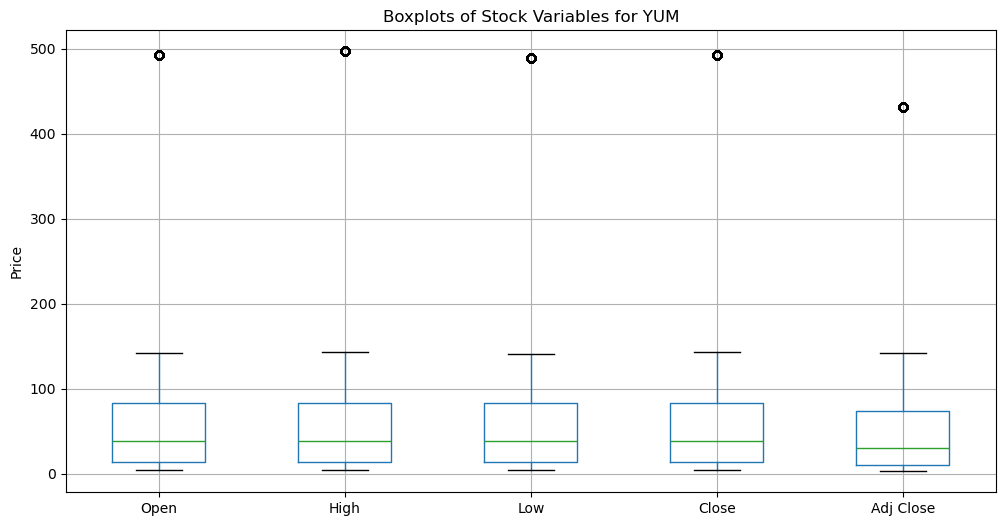

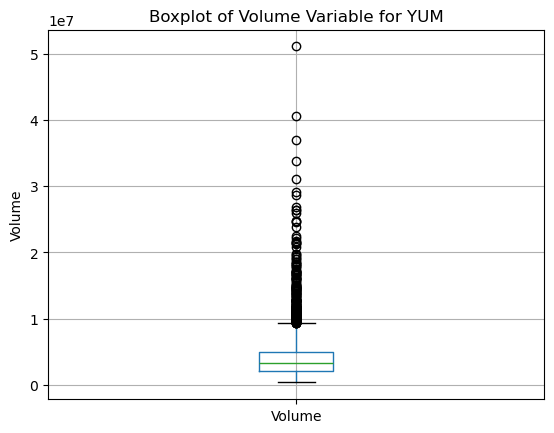

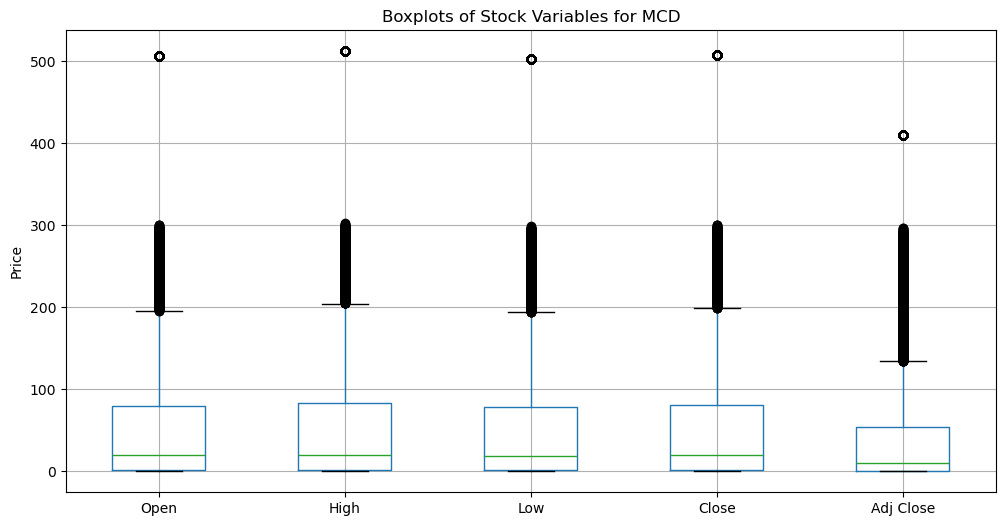

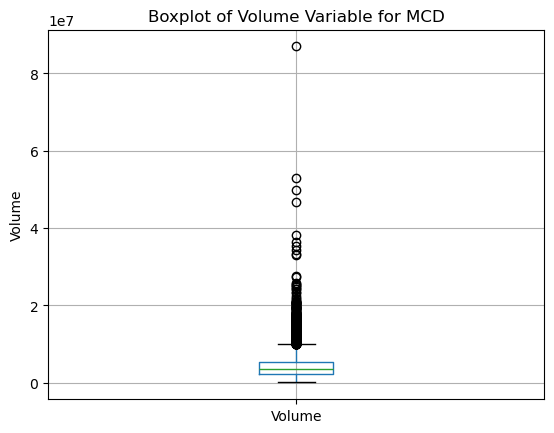

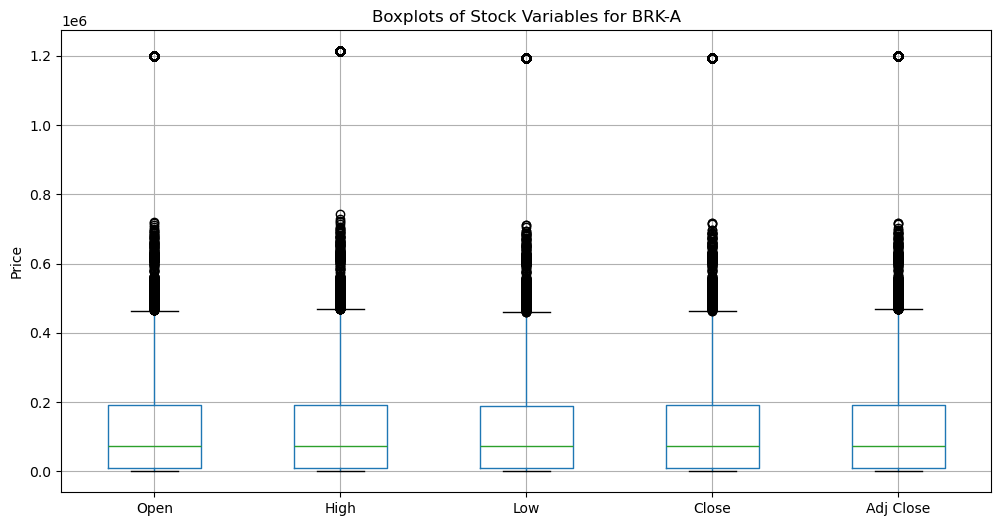

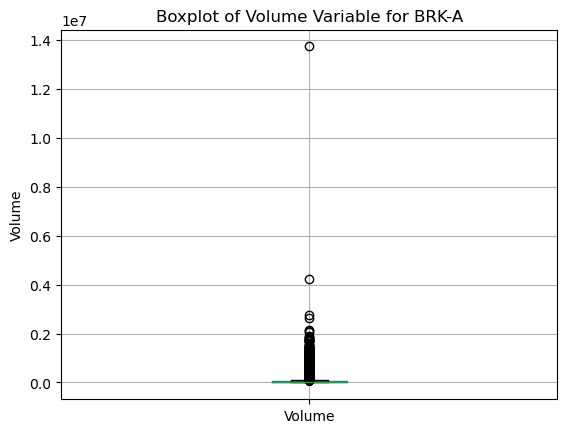

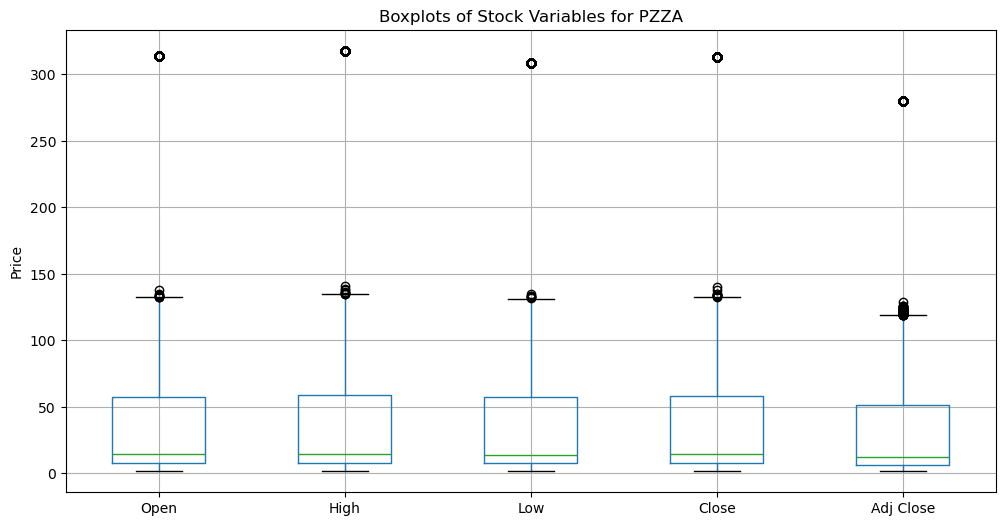

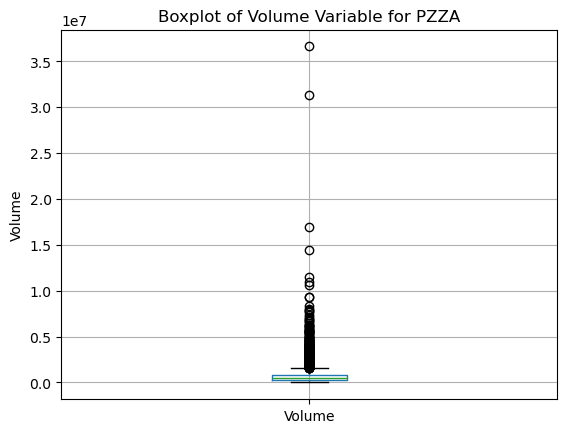

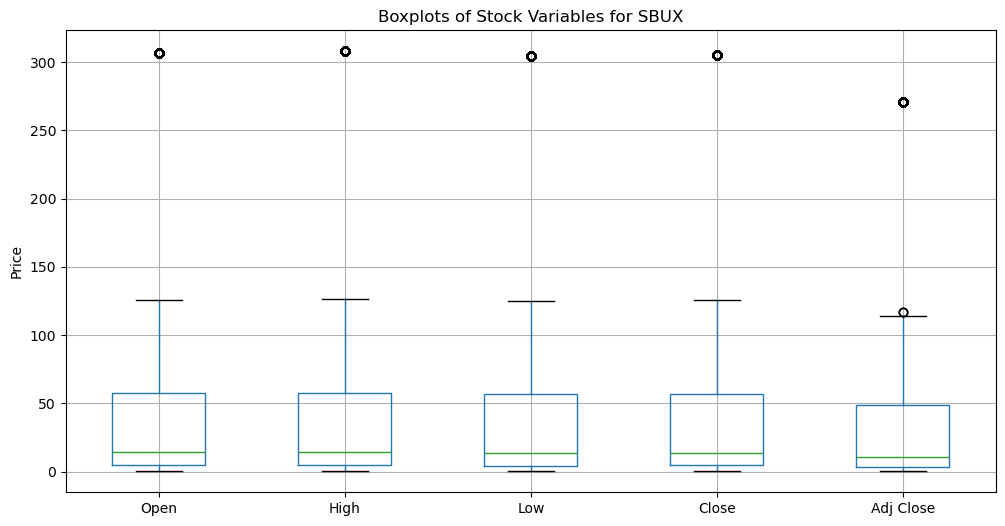

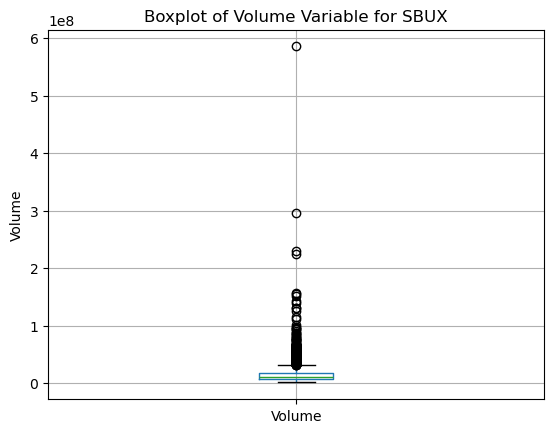

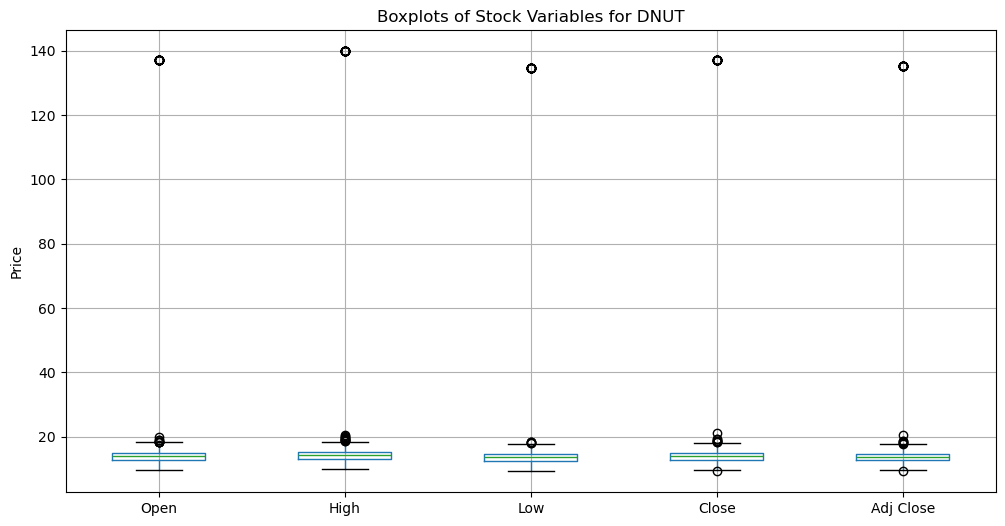

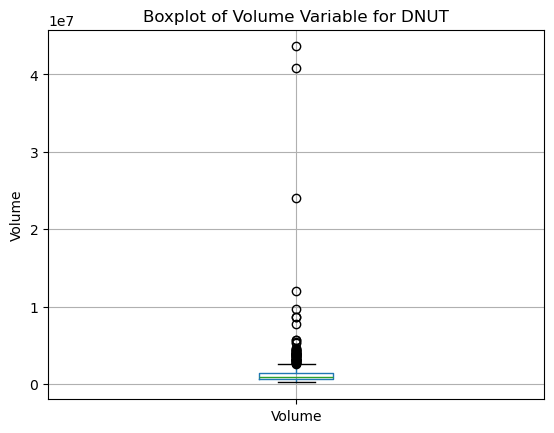

In [1120]:
for df in dataframes:
    company_name = df["Company"][0]
    
    # Create a boxplot for each variable
    plt.figure(figsize=(12, 6))
    df[num_columns[:-1]].boxplot()
    plt.title(f"Boxplots of Stock Variables for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

    plt.figure()
    df[["Volume"]].boxplot()
    plt.title(f"Boxplot of Volume Variable for {company_name}")
    plt.ylabel('Volume')
    plt.grid(True, axis='y')
    plt.show()

It can be observed that all datasets, except for the one from the company QSR, exhibit significant outliers. For the other nine companies, these outliers are located above the 75th percentile, falling into specific ranges considerably higher than this threshold.

To detect outliers and replace them with missing values, given the context of financial time series, we have opted for an approach utilizing sliding windows. The use of sliding windows in financial time series allows us to capture local trends and adapt to dynamic changes in the data, such as seasonal variations or periods of high volatility. This is achieved by using a sliding window (`rolling window`) to calculate the **local median** of each numeric column and comparing the current values to this central trend.

The criterion for identifying an outlier is based on the **relative change**, which measures how much a value deviates from the median relative to its magnitude. If the relative change exceeds a predefined threshold, the value is considered an outlier.

Process Steps
1. **Calculate the sliding median (`rolling_median`)**:
   - A sliding window of size `window_size` is used to calculate the median at each point in the time series.
   - The median is chosen instead of the mean because it is more robust to extreme values (outliers), preventing these values from affecting the central reference.

2. **Fill NaN values at the edges**:
   - Sliding windows produce `NaN` values at the edges of the series, so these are filled using forward (`bfill`) and backward (`ffill`) interpolations to maintain continuity.

3. **Calculate the relative change**:
   - The relative change is defined as:
     $$
     \text{Relative Change} = \frac{|x_t - \text{rolling\_median}|}{\text{rolling\_median}}
     $$
   - This value measures how far a point is from the local central trend.

4. **Identify outliers**:
   - A value is considered an outlier if its relative change exceeds a predefined threshold (`threshold`, e.g., 0.25 or 25%, making the detection highly sensitive).

5. **Replace outliers with `NaN`**:
   - Values identified as outliers are replaced with `NaN` in the DataFrame to prevent them from impacting future analyses.

We used higher `window_size` and `threshold` to manage outliers on the Volume variable, as the scale is different.

In [1121]:
window_size = 30
threshold = 1

for df in dataframes:
    print(df["Company"][0])
    print(f"Rows in {df["Company"][0]}: {df.shape[0]}")
    print(df.isnull().sum())

    rolling_median = df["Volume"].rolling(window=window_size, center=True).median()
    rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')

    relative_change = abs(df["Volume"] - rolling_median) / rolling_median

    outliers = relative_change > threshold
    print(f"Outliers detected in {"Volume"}: {outliers.sum()}")

    df.loc[outliers, "Volume"] = np.nan

    print(df.isnull().sum())
    print("******************************************************************************")


LKNCY
Rows in LKNCY: 1350
Date          0
Open         65
High         67
Low          66
Close        63
Adj Close    66
Volume       67
Company       0
dtype: int64
Outliers detected in Volume: 143
Date           0
Open          65
High          67
Low           66
Close         63
Adj Close     66
Volume       210
Company        0
dtype: int64
******************************************************************************
DPZ
Rows in DPZ: 5088
Date           0
Open         246
High         248
Low          249
Close        248
Adj Close    250
Volume       254
Company        0
dtype: int64
Outliers detected in Volume: 425
Date           0
Open         246
High         248
Low          249
Close        248
Adj Close    250
Volume       679
Company        0
dtype: int64
******************************************************************************
QSR
Rows in QSR: 2459
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Company      

/tmp/ipykernel_8556/1254363800.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_8556/1254363800.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_8556/1254363800.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_8556/1254363800.py:10: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffil

In [1122]:
window_size = 10
threshold = 0.25

for df in dataframes:
    print(df["Company"][0])
    print(f"Rows in {df["Company"][0]}: {df.shape[0]}")
    print(df.isnull().sum())

    for column in num_columns[:-1]:

        rolling_median = df[column].rolling(window=window_size, center=True).median()
        rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')

        relative_change = abs(df[column] - rolling_median) / rolling_median

        outliers = relative_change > threshold
        print(f"Outliers detected in {column}: {outliers.sum()}")

        df.loc[outliers, column] = np.nan

    print(df.isnull().sum())
    print("******************************************************************************")


LKNCY
Rows in LKNCY: 1350
Date           0
Open          65
High          67
Low           66
Close         63
Adj Close     66
Volume       210
Company        0
dtype: int64
Outliers detected in Open: 71
Outliers detected in High: 79
Outliers detected in Low: 65
Outliers detected in Close: 77
Outliers detected in Adj Close: 74
Date           0
Open         136
High         146
Low          131
Close        140
Adj Close    140
Volume       210
Company        0
dtype: int64
******************************************************************************
DPZ
Rows in DPZ: 5088
Date           0
Open         246
High         248
Low          249
Close        248
Adj Close    250
Volume       679
Company        0
dtype: int64
Outliers detected in Open: 146
Outliers detected in High: 134
Outliers detected in Low: 140
Outliers detected in Close: 130
Outliers detected in Adj Close: 137
Date           0
Open         392
High         382
Low          389
Close        378
Adj Close    387
Volume   

/tmp/ipykernel_8556/3146784517.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_8556/3146784517.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_8556/3146784517.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffill')
/tmp/ipykernel_8556/3146784517.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_median = rolling_median.fillna(method='bfill').fillna(method='ffil

We can now check again the outliers present in the boxplots. We can observe how there considerably less outliers.

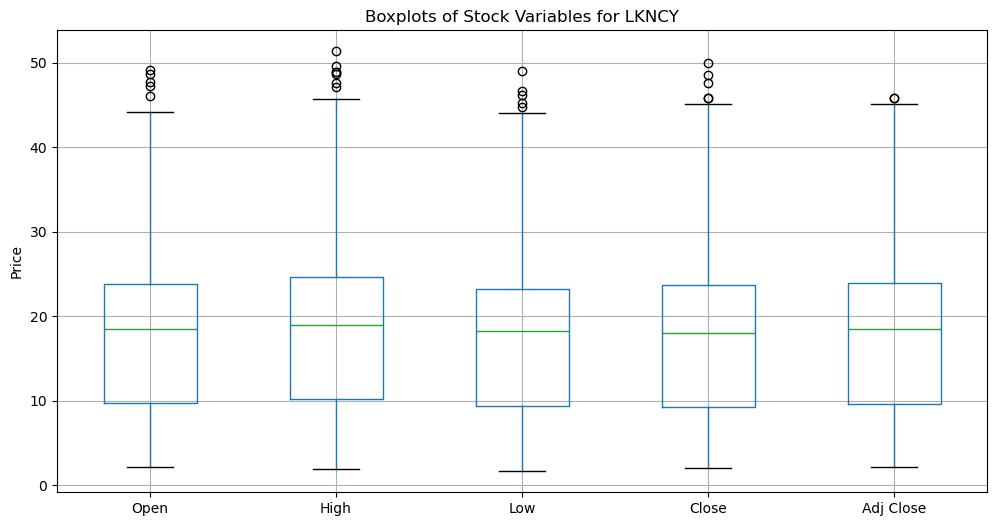

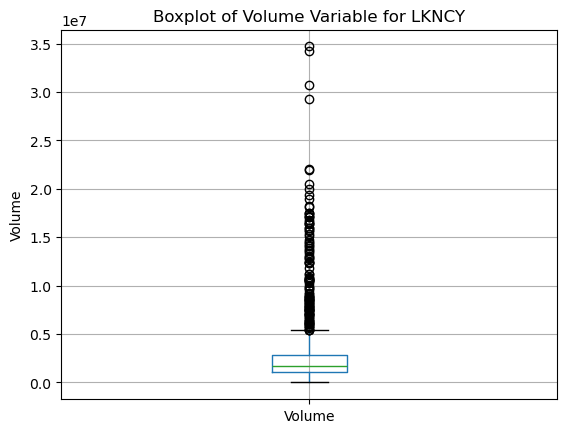

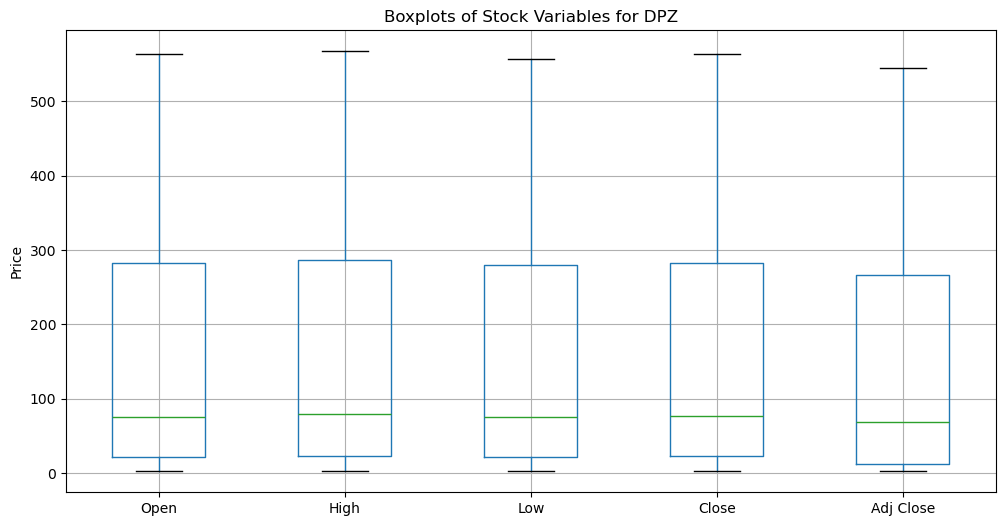

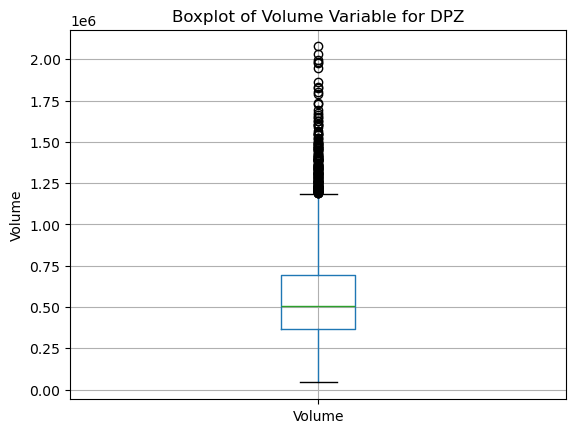

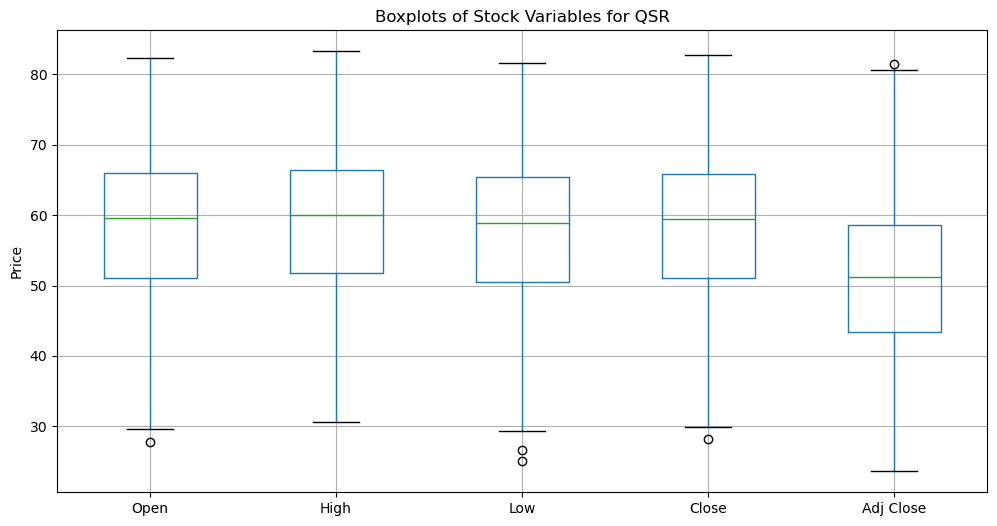

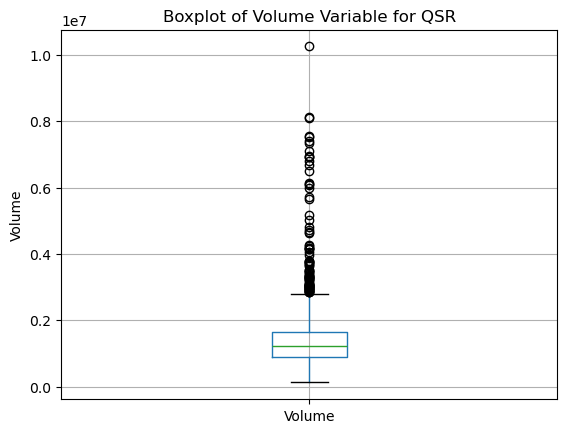

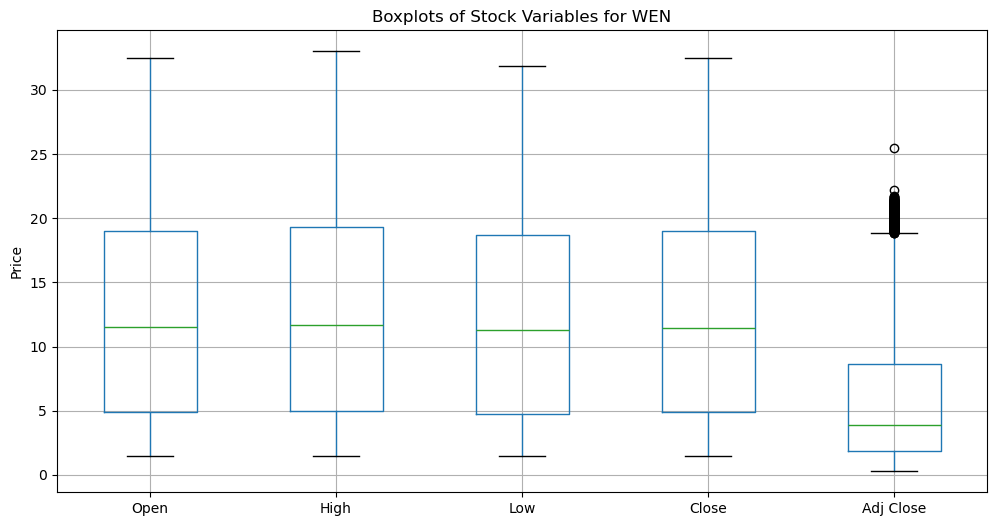

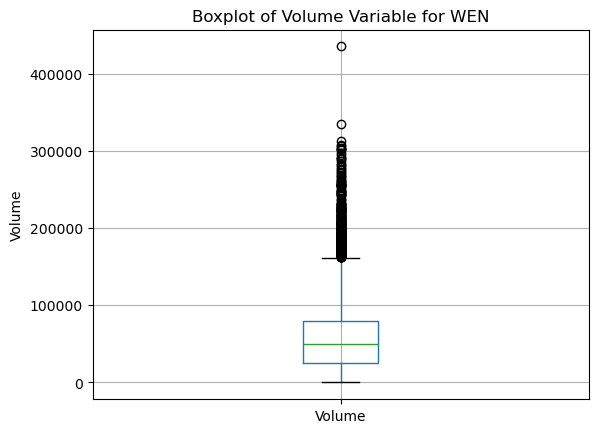

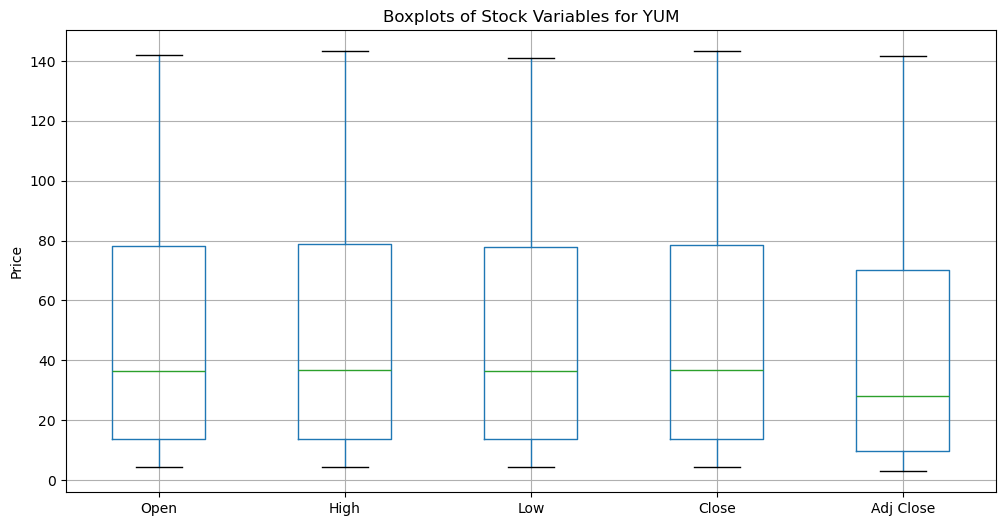

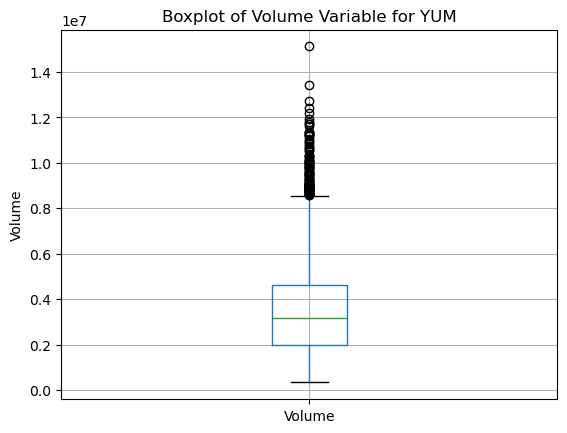

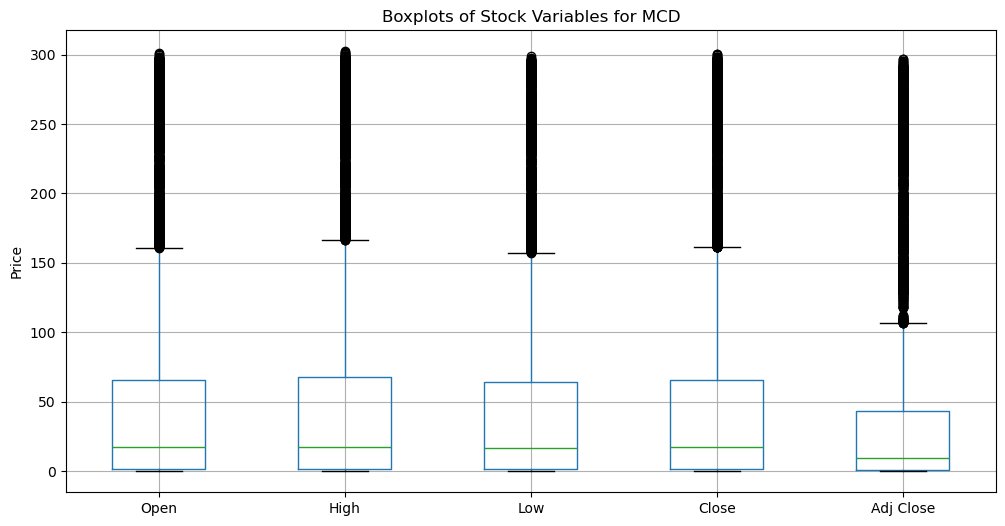

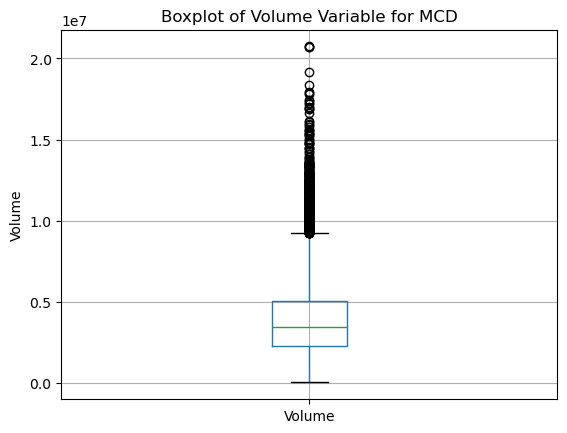

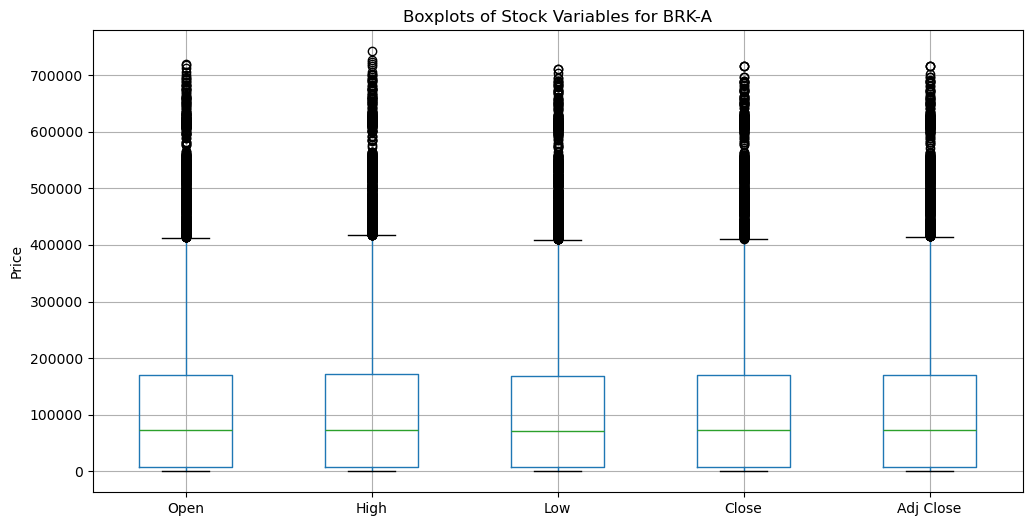

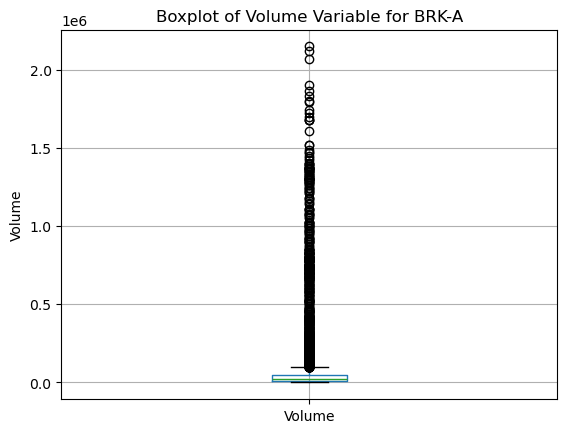

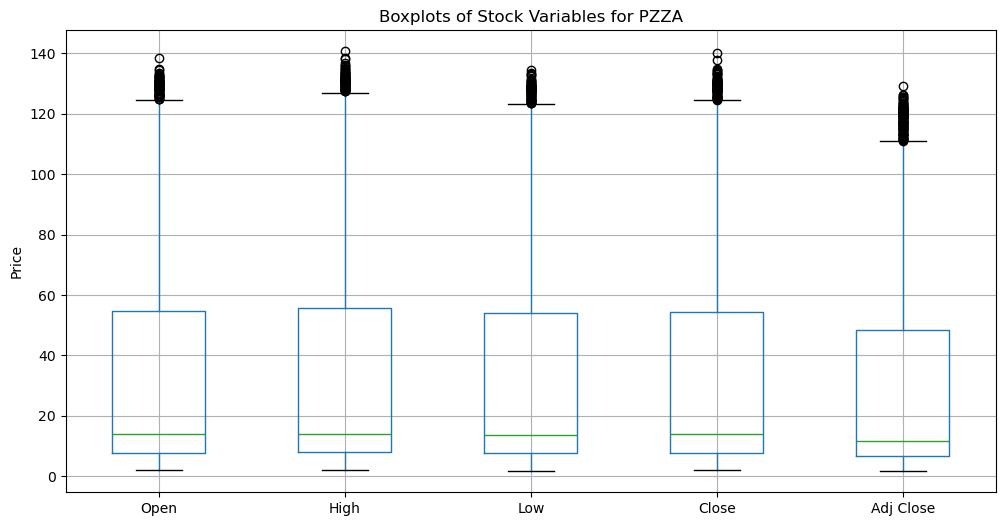

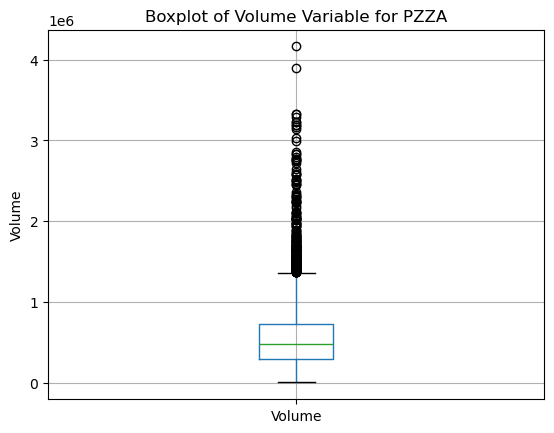

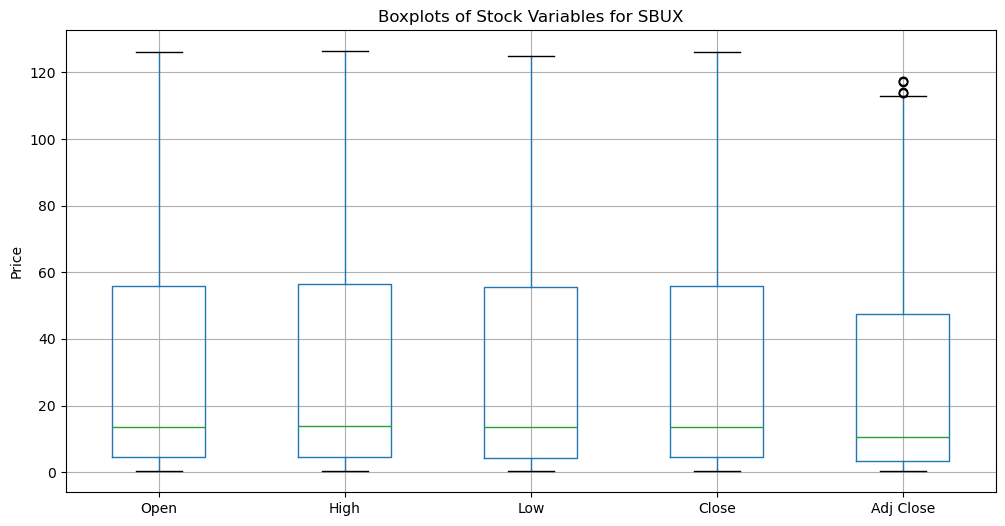

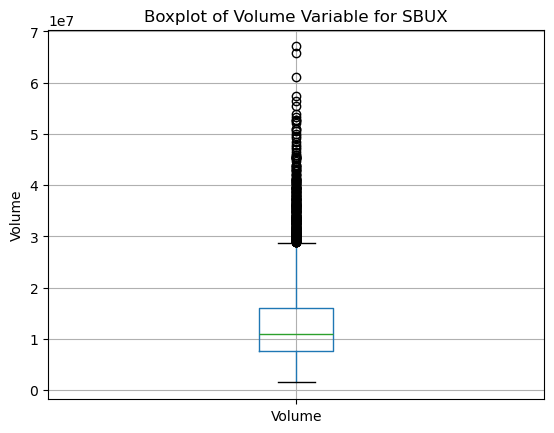

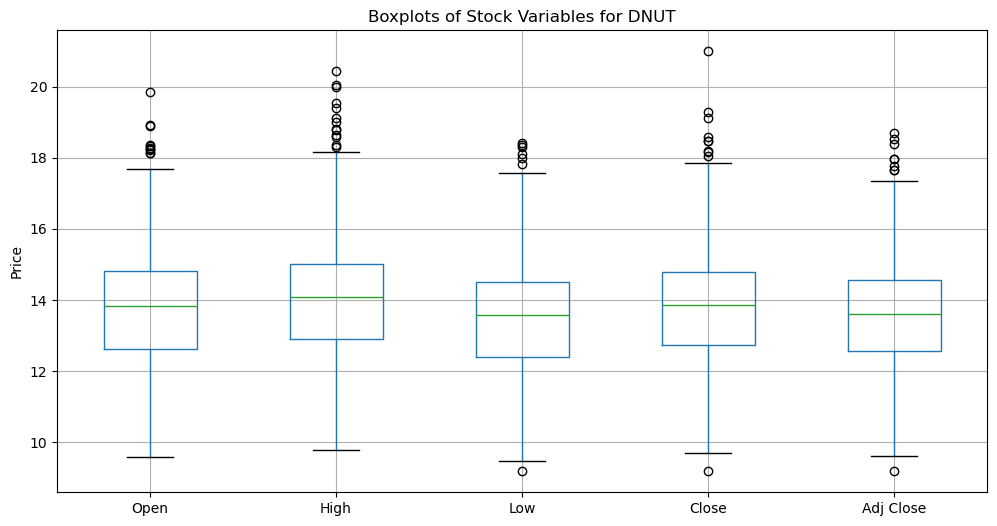

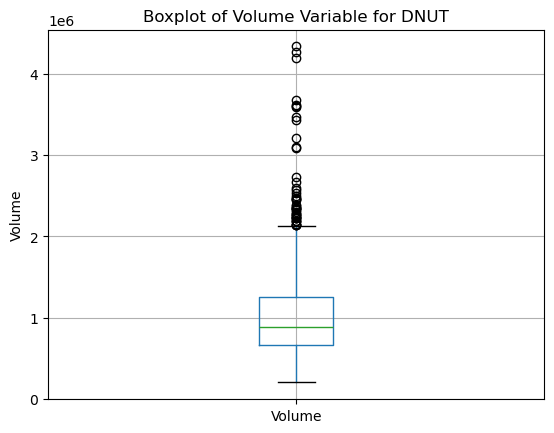

In [1123]:
for df in dataframes:
    company_name = df["Company"][0]
    
    # Create a boxplot for each variable
    plt.figure(figsize=(12, 6))
    df[num_columns[:-1]].boxplot()
    plt.title(f"Boxplots of Stock Variables for {company_name}")
    plt.ylabel('Price')
    plt.grid(True, axis='y')
    plt.show()

    plt.figure()
    df[["Volume"]].boxplot()
    plt.title(f"Boxplot of Volume Variable for {company_name}")
    plt.ylabel('Volume')
    plt.grid(True, axis='y')
    plt.show()

As we can also observe in the output of the cell where outliers were replaced with NaN values, this transformation has resulted in a large number of missing values for the "Volume" variable in each company. As shown in the following tables, the number of missing values for the "Volume" variable exceeds 50% of the observations in some cases.

In [1124]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

Company  Date   Open   High   Low  Close  Adj Close  Volume
LKNCY      0.0   0.0  10.07  10.81  9.70  10.37      10.37   15.56
DPZ        0.0   0.0   7.70   7.51  7.65   7.43       7.61   13.35
QSR        0.0   0.0   0.00   0.00  0.00   0.00       0.00    7.36
WEN        0.0   0.0   7.84   7.43  7.76   7.53       7.61   20.76
YUM        0.0   0.0   7.40   7.54  7.68   7.54       7.40   12.15
MCD        0.0   0.0   7.55   7.39  7.40   7.32       7.42   11.46
BRK-A      0.0   0.0   7.39   7.36  7.46   7.38       7.36   18.87
PZZA       0.0   0.0   7.36   7.52  7.43   7.66       7.48   15.87
SBUX       0.0   0.0   7.56   7.44  7.92   7.70       7.51   12.50
DNUT       0.0   0.0   7.48   8.22  9.69   7.61       7.48   17.06

In [1125]:
for df in dataframes:
    print(df["Volume"].describe())

count    1.140000e+03
mean     2.818600e+06
std      3.670381e+06
min      0.000000e+00
25%      1.088175e+06
50%      1.744300e+06
75%      2.802825e+06
max      3.470920e+07
Name: Volume, dtype: float64
count    4.409000e+03
mean     5.636805e+05
std      2.797807e+05
min      4.300000e+04
25%      3.683000e+05
50%      5.091000e+05
75%      6.955000e+05
max      2.077600e+06
Name: Volume, dtype: float64
count    2.278000e+03
mean     1.391255e+06
std      8.367087e+05
min      1.282000e+05
25%      8.863250e+05
50%      1.232350e+06
75%      1.654825e+06
max      1.024860e+07
Name: Volume, dtype: float64
count      8869.000000
mean      59047.738409
std       45982.269612
min           0.000000
25%       25600.000000
50%       49881.193146
75%       80104.438410
max      435304.349287
Name: Volume, dtype: float64
count    5.975000e+03
mean     3.511294e+06
std      1.920127e+06
min      3.404000e+05
25%      1.980050e+06
50%      3.173427e+06
75%      4.621389e+06
max      1.511975e

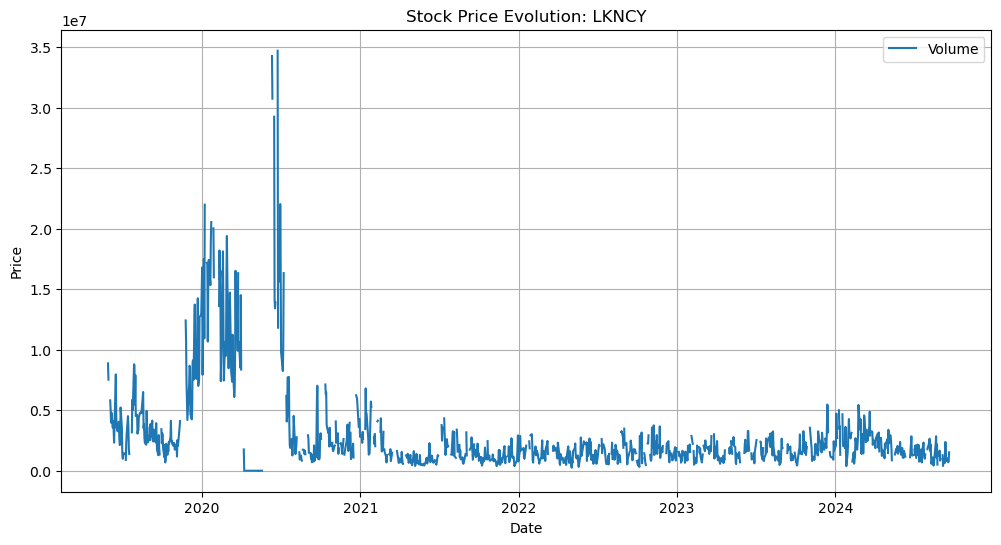

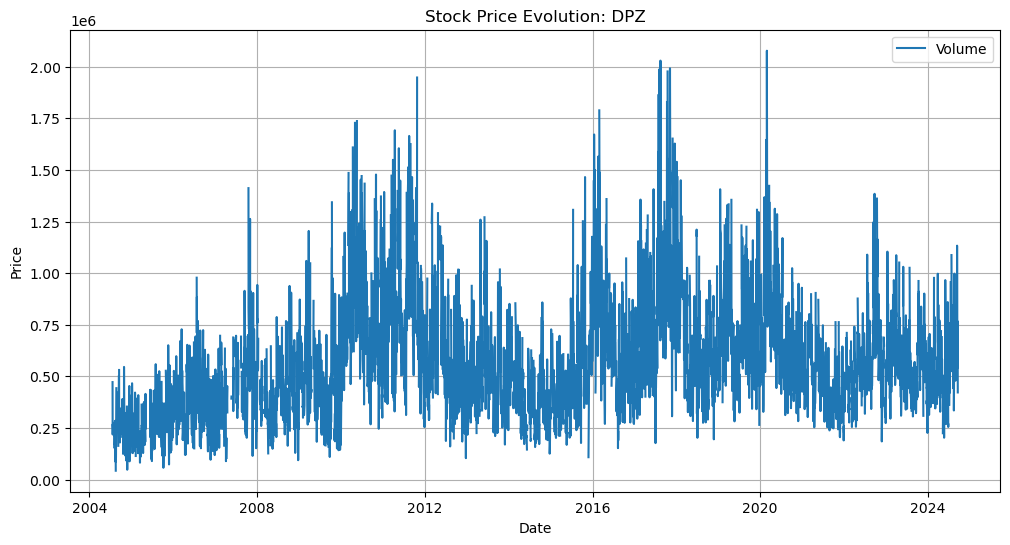

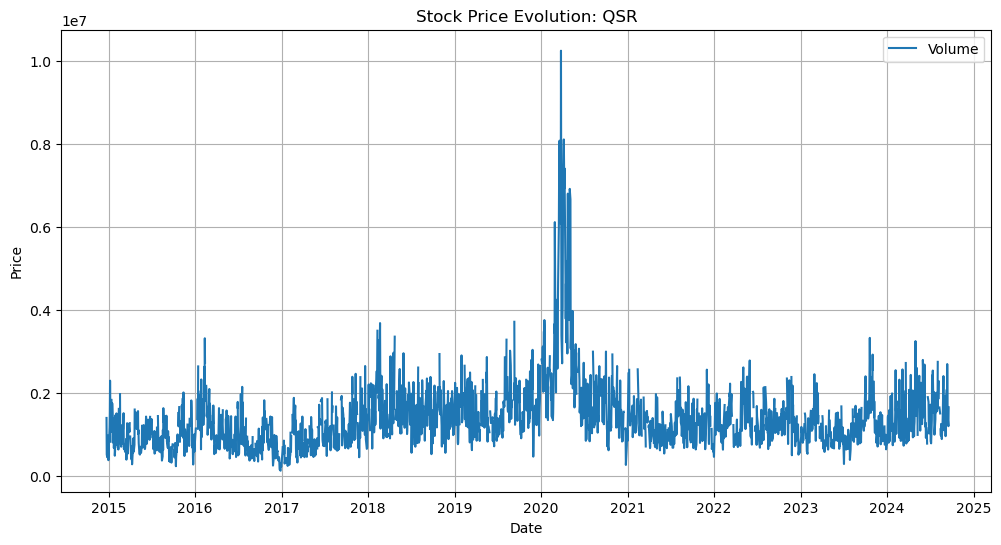

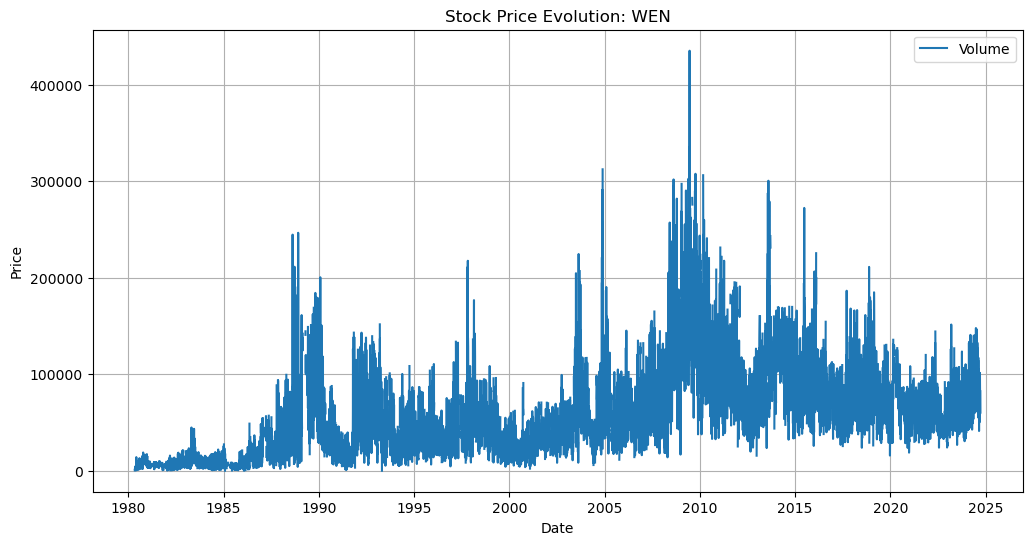

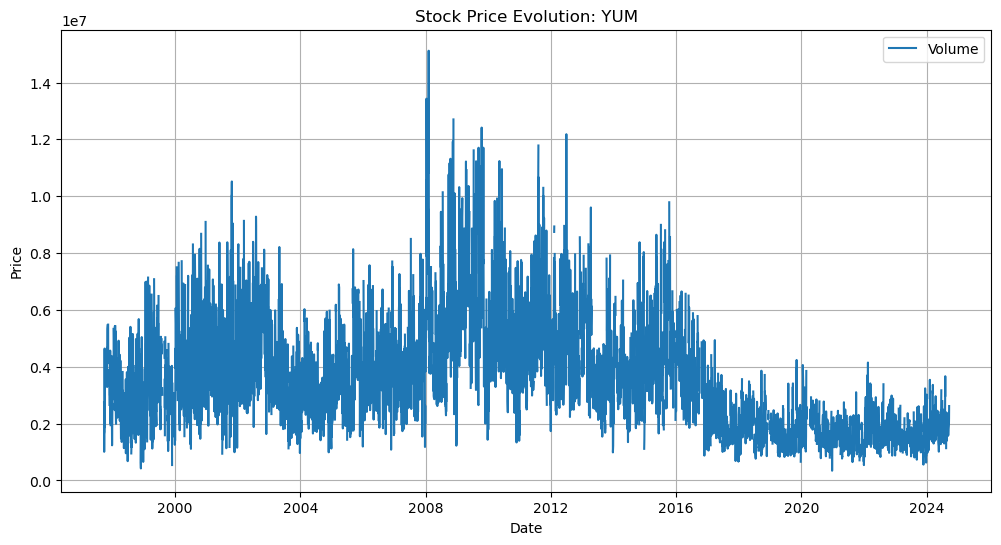

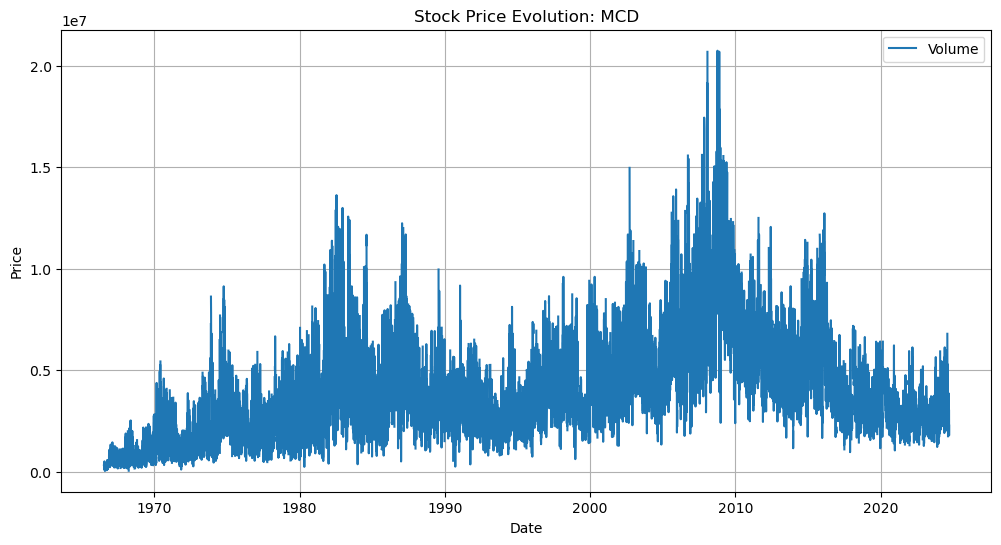

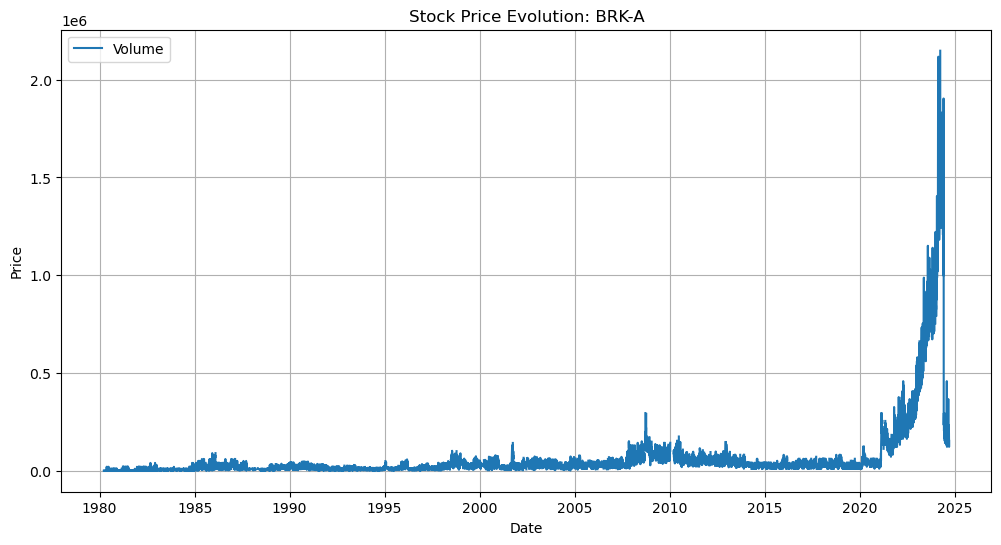

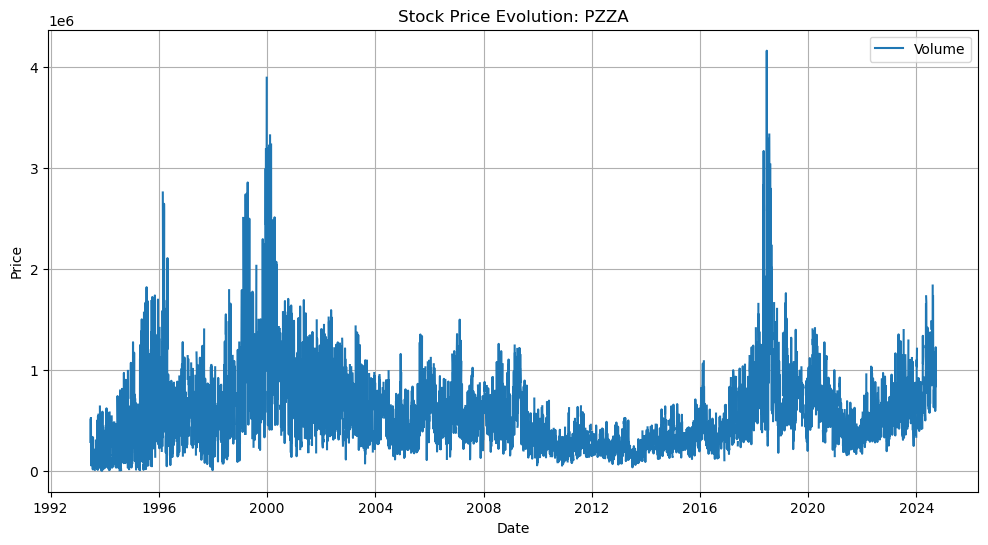

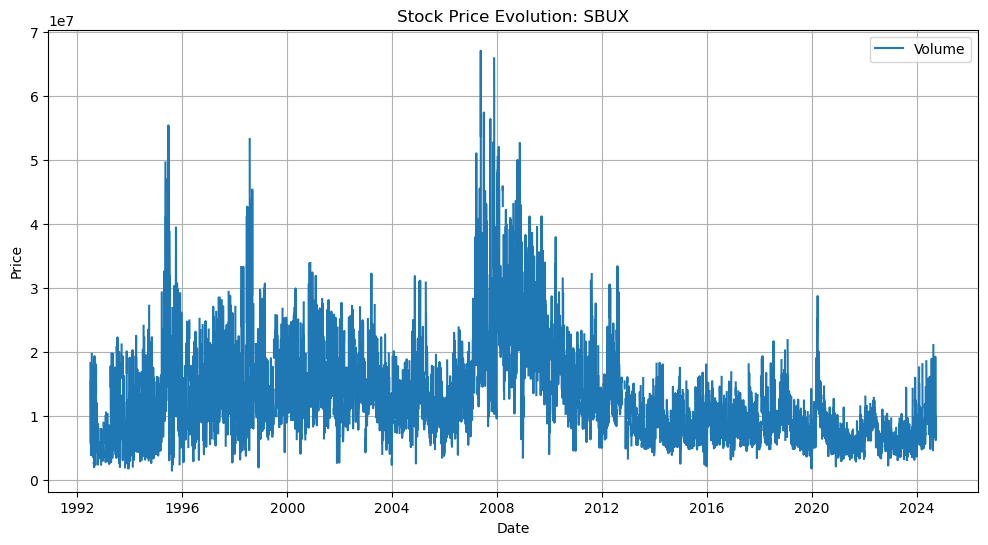

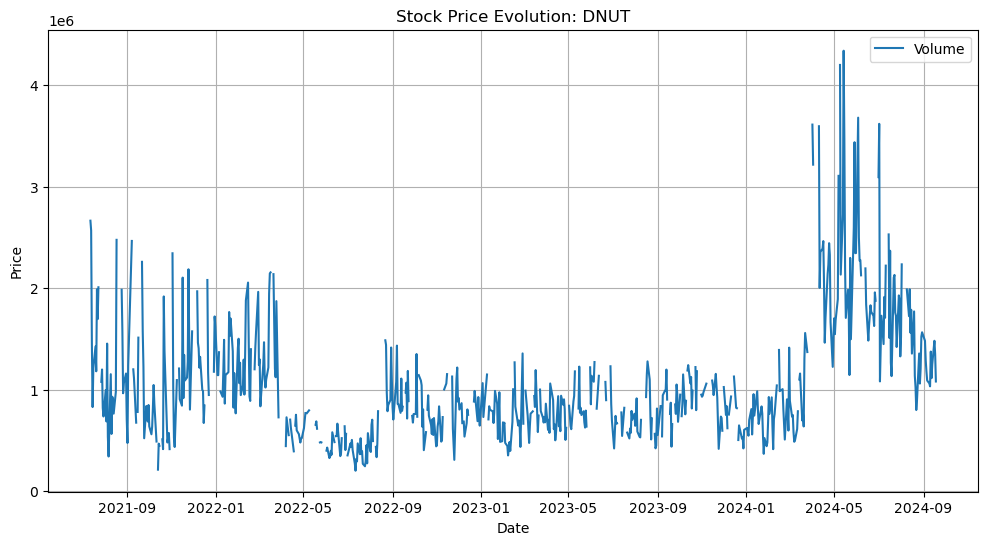

In [1126]:
for df in dataframes:
    # Ensure the 'Date' column is parsed as datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the data by date for proper plotting
    df.sort_values('Date', inplace=True)
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    plt.plot(df['Date'], df['Volume'], label='Volume')
        
    # Chart formatting
    plt.title(f"Stock Price Evolution: {df["Company"][0]}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Replace Missing Data

We used **interpolation** as the primary technique to replace missing values in the time series. Interpolation involves estimating the missing values based on adjacent known data, leveraging the continuity of the time series.

Interpolation Process
1. **Method Selection**:
   - We opted for **linear interpolation**, which assumes that data changes uniformly between the nearest known points.
   - This method is suitable for time series with smooth transitions and relatively stable patterns.

2. **Filling Missing Values**:
   - Each `NaN` value was estimated by calculating the slope between the nearest known points (previous and next) and assigning a proportional value within the interval.
   - For values at the start or end of the series, where sufficient data points were unavailable, forward and backward propagation methods were used as needed.

For the "Volume" variable, it was decided not to replace its missing values using any technique. In exercises where this variable is needed (7 and 8), the missing values will simply be discarded. We believe this approach is better than imputing values using any method, as it avoids introducing artificial values given the large proportion of missing data.

In [1127]:
num_columns[:]

['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [1128]:
window_size = 30

for df in dataframes:
    df['Volume'] = df['Volume'].combine_first(
        df['Volume'].rolling(window=window_size, min_periods=1).median()
    )


In [1129]:
for df in dataframes:
    print(f"Initial empty Close count: {df['Close'].isna().sum()}")
    print(f"Initial empty Adj Close count: {df['Adj Close'].isna().sum()}")
    
    # Round all numerical columns to 2 decimal places
    df.update(df.round(2))
    
    # Create 'Close/Adj Close Ratio' column
    df['Close/Adj Close Ratio'] = df['Close'] / df['Adj Close']

    # Fill missing 'Close' and 'Adj Close' cells using the ratio from the row above
    for index in range(1, len(df)):
        if pd.isna(df.loc[index, 'Close']) and not pd.isna(df.loc[index, 'Adj Close']):
            df.loc[index, 'Close'] = df.loc[index, 'Adj Close'] * df.loc[index - 1, 'Close/Adj Close Ratio']
        elif pd.isna(df.loc[index, 'Adj Close']) and not pd.isna(df.loc[index, 'Close']):
            df.loc[index, 'Adj Close'] = df.loc[index, 'Close'] / df.loc[index - 1, 'Close/Adj Close Ratio']

    # # Recalculate 'Close/Adj Close Ratio' and round again
    # df['Close/Adj Close Ratio'] = df['Close'] / df['Adj Close']
    # df.update(df.round(2))

    df.drop(columns=['Close/Adj Close Ratio'], inplace=True)

    # Count the number of empty 'Close' and 'Adj Close' cells
    empty_close_count = df['Close'].isna().sum()
    empty_adj_close_count = df['Adj Close'].isna().sum()    
    print(f"Final empty Close count: {df['Close'].isna().sum()}")
    print(f"Final empty Adj Close count: {df['Adj Close'].isna().sum()}")


Initial empty Close count: 140
Initial empty Adj Close count: 140
Final empty Close count: 69
Final empty Adj Close count: 64
Initial empty Close count: 378
Initial empty Adj Close count: 387
Final empty Close count: 74
Final empty Adj Close count: 79
Initial empty Close count: 0
Initial empty Adj Close count: 0
Final empty Close count: 0
Final empty Adj Close count: 0
Initial empty Close count: 843
Initial empty Adj Close count: 852
Final empty Close count: 207
Final empty Adj Close count: 213
Initial empty Close count: 513
Initial empty Adj Close count: 503
Final empty Close count: 107
Final empty Adj Close count: 106
Initial empty Close count: 1073
Initial empty Adj Close count: 1088
Final empty Close count: 217
Final empty Adj Close count: 217
Initial empty Close count: 828
Initial empty Adj Close count: 826
Final empty Close count: 166
Final empty Adj Close count: 154
Initial empty Close count: 604
Initial empty Adj Close count: 590
Final empty Close count: 147
Final empty Adj Clo

In [1130]:
for df in dataframes:
    print(f"Procesando: {df['Company'][0]}")
    print("Valores NaN antes de la interpolación:")
    print(df.isnull().sum())

    for column in num_columns[:-3]:

        df[column] = df[column].interpolate(method='linear', limit_direction='both')

    print("Valores NaN después de la interpolación:")
    print(df.isnull().sum())
    print("******************************************************************************")


Procesando: LKNCY
Valores NaN antes de la interpolación:
Date           0
Open         136
High         146
Low          131
Close         69
Adj Close     64
Volume         1
Company        0
dtype: int64
Valores NaN después de la interpolación:
Date          0
Open          0
High          0
Low           0
Close        69
Adj Close    64
Volume        1
Company       0
dtype: int64
******************************************************************************
Procesando: DPZ
Valores NaN antes de la interpolación:
Date           0
Open         392
High         382
Low          389
Close         74
Adj Close     79
Volume         6
Company        0
dtype: int64
Valores NaN después de la interpolación:
Date          0
Open          0
High          0
Low           0
Close        74
Adj Close    79
Volume        6
Company       0
dtype: int64
******************************************************************************
Procesando: QSR
Valores NaN antes de la interpolación:
Date         

Finally, we can observe the time series obtained for each dataset after the interpolation process.

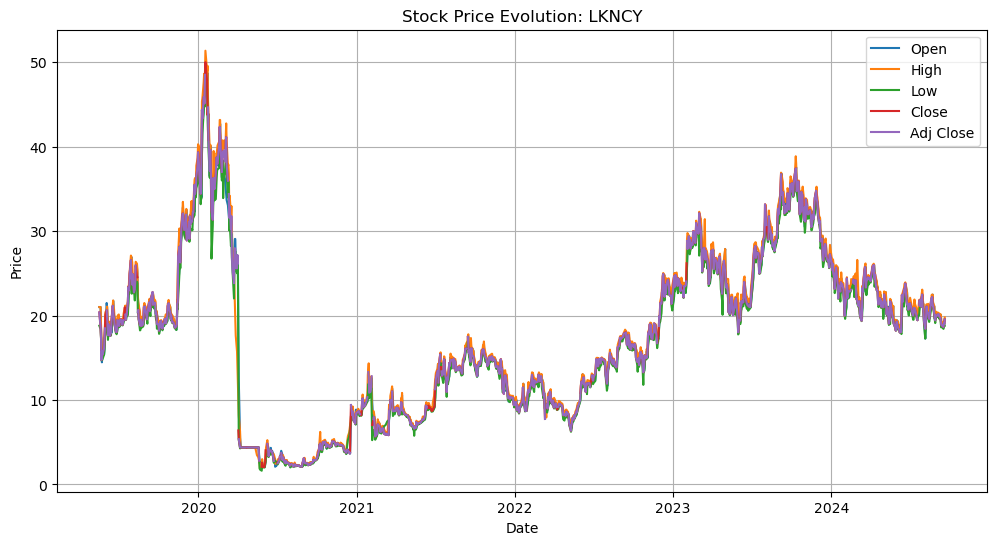

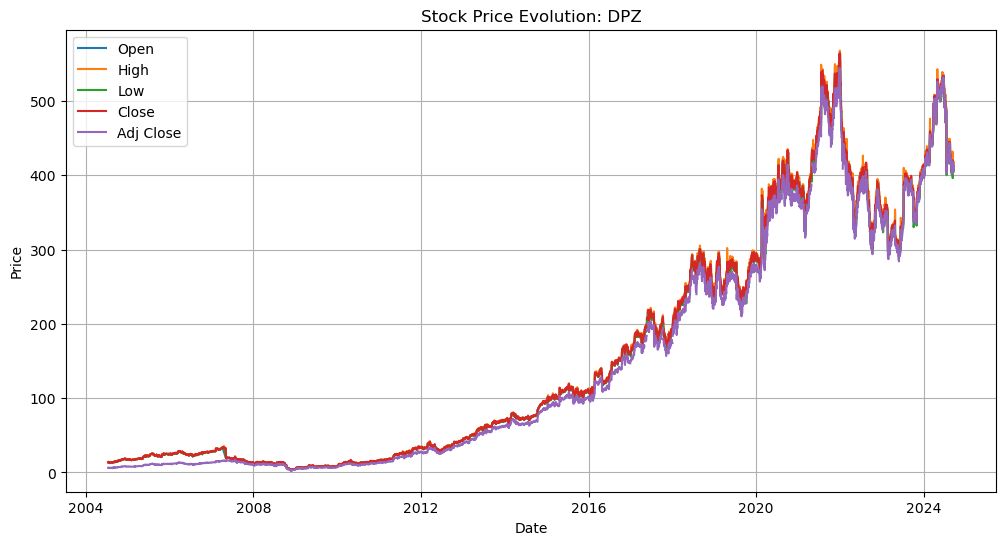

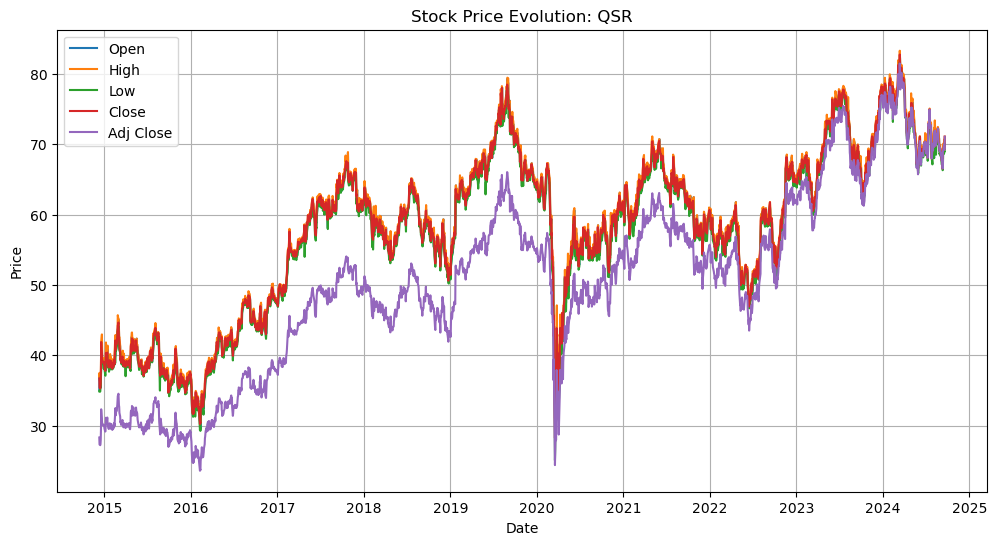

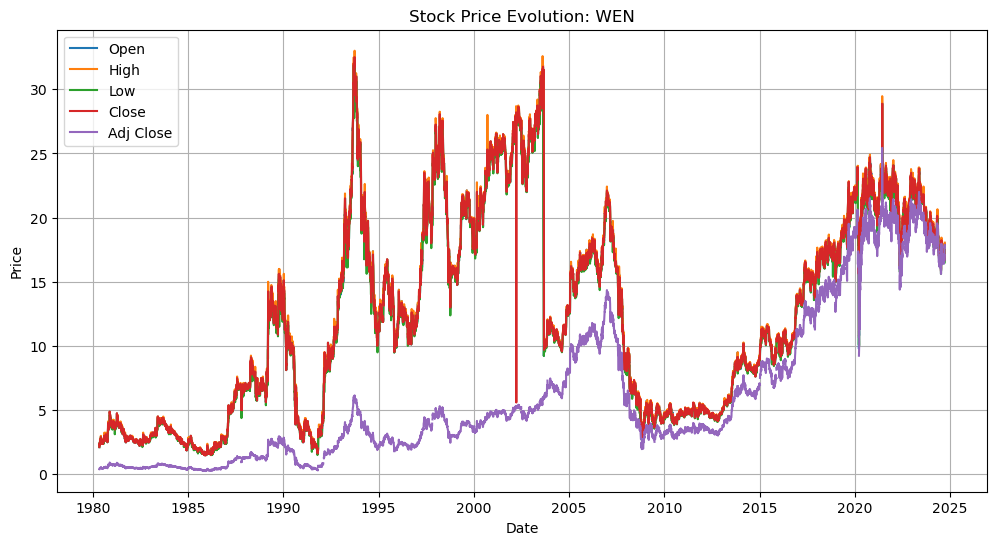

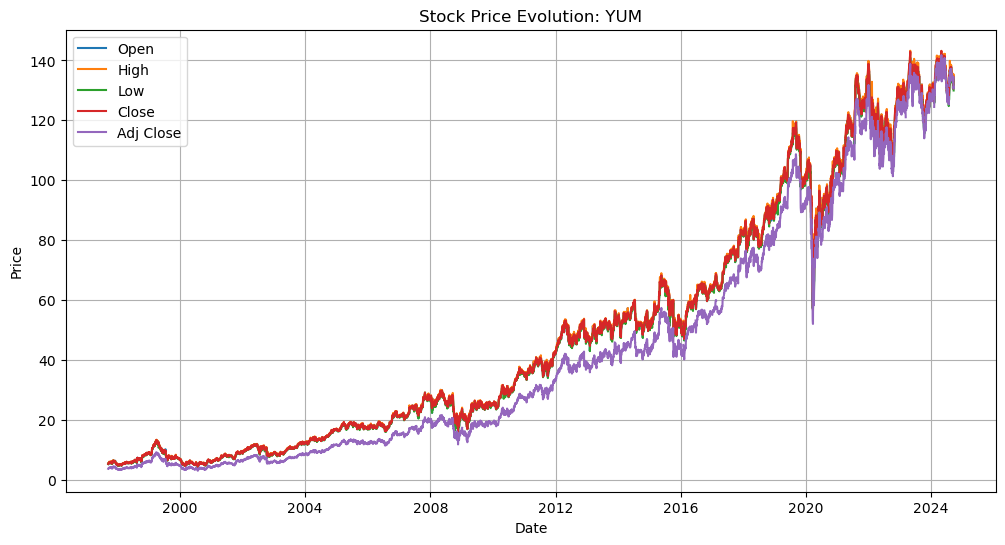

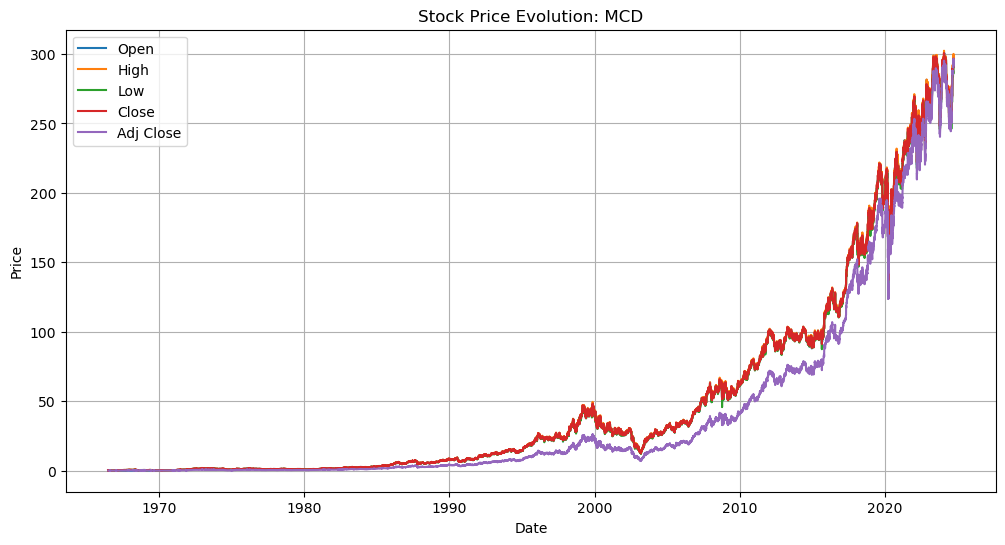

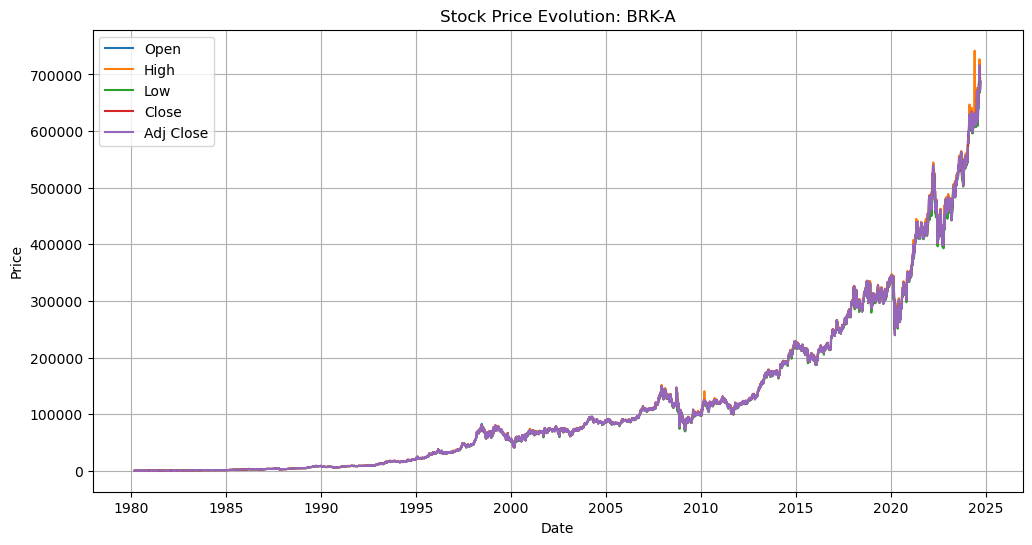

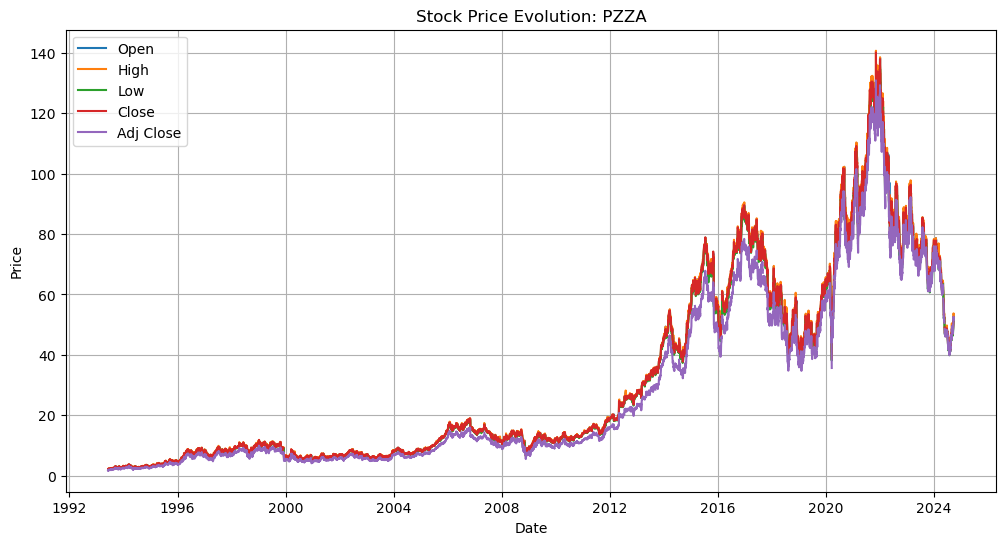

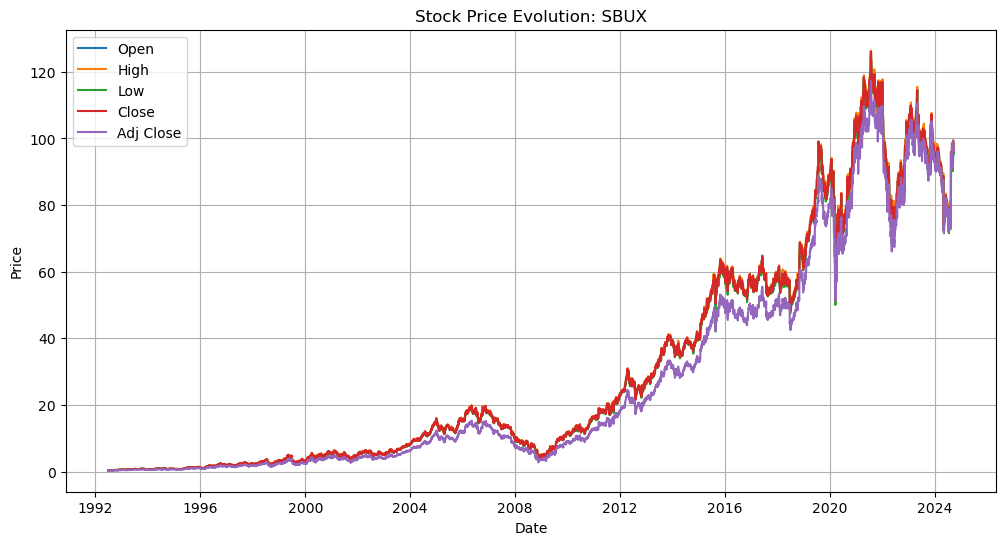

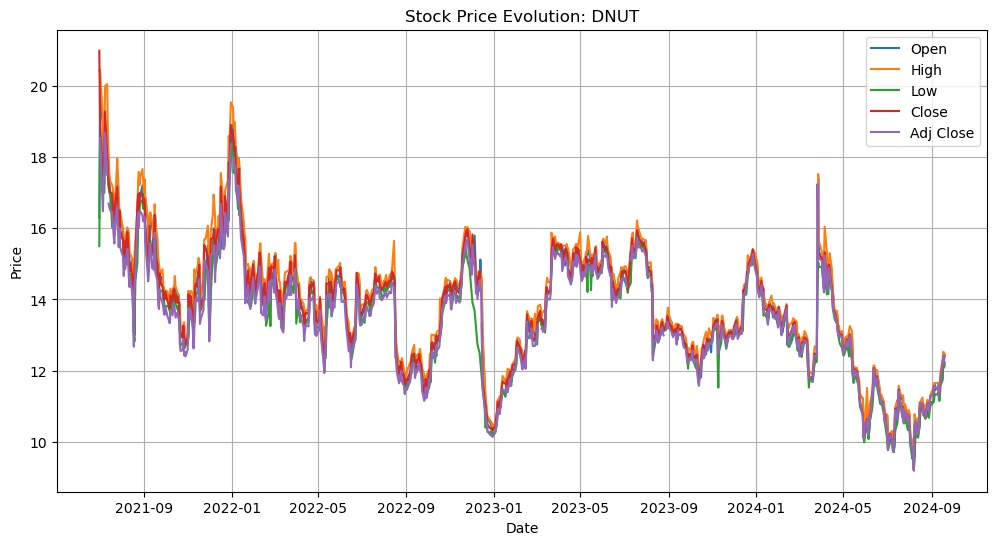

In [1131]:
for df in dataframes:
    # Ensure the 'Date' column is parsed as datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Sort the data by date for proper plotting
    df.sort_values('Date', inplace=True)
    
    # Plot the line chart
    plt.figure(figsize=(12, 6))
    for variable in num_columns[:-1]:
        plt.plot(df["Date"], df[variable], label=variable)
    # plt.plot(df['Date'], df['Open'], label='Open')
    # plt.plot(df['Date'], df['High'], label='High')
    # plt.plot(df['Date'], df['Low'], label='Low')
    # plt.plot(df['Date'], df['Close'], label='Close')
    # plt.plot(df['Date'], df['Adj Close'], label='Adj Close')
    
    # Chart formatting
    plt.title(f"Stock Price Evolution: {df["Company"][0]}")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [1132]:
results = []
company_names = []

for df in dataframes:
    company_name = df["Company"][0]
    company_names.append(company_name)
    total_rows = len(df)
    null_percentages = (df.isnull().sum() / total_rows) * 100
    
    result = {"Company": company_name}
    result.update(null_percentages.to_dict())
    results.append(result)

final_df = pd.DataFrame(results, index=company_names)
final_df = final_df.round(2)
final_df

Company  Date  Open  High  Low  Close  Adj Close  Volume
LKNCY      0.0   0.0   0.0   0.0  0.0   5.11       4.74    0.07
DPZ        0.0   0.0   0.0   0.0  0.0   1.45       1.55    0.12
QSR        0.0   0.0   0.0   0.0  0.0   0.00       0.00    0.00
WEN        0.0   0.0   0.0   0.0  0.0   1.85       1.90    0.02
YUM        0.0   0.0   0.0   0.0  0.0   1.57       1.56    0.03
MCD        0.0   0.0   0.0   0.0  0.0   1.48       1.48    0.00
BRK-A      0.0   0.0   0.0   0.0  0.0   1.48       1.37    0.07
PZZA       0.0   0.0   0.0   0.0  0.0   1.86       1.78    0.11
SBUX       0.0   0.0   0.0   0.0  0.0   1.70       1.60    0.04
DNUT       0.0   0.0   0.0   0.0  0.0   1.10       1.35    0.74

### 1. For each dataset:
- Print the number of rows and columns.
- Display the column names and their data types.

In [1133]:
# Iterate over files in the directory
for df in dataframes:
    # Print the dataset name
    print(f"{df["Company"][0]}:")
    # Print the shape of the DataFrame
    print(f"- Number of rows and columns: {df.shape}")
    # Print the column names
    print(f"- Columns: {list(df.columns)}")
    # Print the data types of each column
    print(f"- Data types:")
    print(df.dtypes)
    print("-" * 50)  # Separator for readability

LKNCY:
- Number of rows and columns: (1350, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company']
- Data types:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
Company              object
dtype: object
--------------------------------------------------
DPZ:
- Number of rows and columns: (5088, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company']
- Data types:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
Company              object
dtype: object
--------------------------------------------------
QSR:
- Number of rows and columns: (2459, 8)
- Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Company']

### 2. Extract all rows where the date is in the year 2023.
- Print the number of rows.
- Visualize the `Close` price trend for this period.

In [1134]:
for df in dataframes:
    company_name = df["Company"][0]
    df_2023 = df[df["Date"].dt.year == 2023]
    print(f"The number of observations for {company_name} for year 2023 is {df_2023.shape[0]}")

The number of observations for LKNCY for year 2023 is 251
The number of observations for DPZ for year 2023 is 250
The number of observations for QSR for year 2023 is 250
The number of observations for WEN for year 2023 is 251
The number of observations for YUM for year 2023 is 250
The number of observations for MCD for year 2023 is 250
The number of observations for BRK-A for year 2023 is 250
The number of observations for PZZA for year 2023 is 250
The number of observations for SBUX for year 2023 is 250
The number of observations for DNUT for year 2023 is 252


In [1135]:
dfm["Date"] = pd.to_datetime(dfm["Date"], format="%Y-%m-%d")
dfm_2023 = dfm[dfm["Date"].dt.year == 2023]
print(f"The number of observations in the merged dataframe for year 2023 is {dfm_2023.shape[0]}")

The number of observations in the merged dataframe for year 2023 is 2504


### 3. For each company, find the day with the highest `Close` price.
- Display the date alongside the price.


In [1136]:
# Dictionary to store results
results = {"Company": [], "Close": [], "Date": []}

for df in dataframes:
    # Extract the company name
    company_name = df["Company"].iloc[0]
    
    # Find the day with the highest Close price
    max_close_row = df.loc[df["Close"].idxmax()]
    max_date = max_close_row["Date"]
    max_close_price = max_close_row["Close"]
    
    # Append to results dictionary
    results["Company"].append(company_name)
    results["Close"].append(max_close_price)
    results["Date"].append(max_date)

# Display the results

results_df = pd.DataFrame(results)
print(results_df)



  Company      Close       Date
0   LKNCY      50.02 2020-01-17
1     DPZ     564.33 2021-12-31
2     QSR      82.75 2024-03-13
3     WEN      32.50 1993-09-29
4     YUM     143.19 2024-04-29
5     MCD     300.53 2024-01-19
6   BRK-A  715910.00 2024-09-03
7    PZZA     140.01 2021-11-04
8    SBUX     126.06 2021-07-26
9    DNUT      21.00 2021-07-01



### 4. Group the data by month and calculate the average `Close` price for each company.
- Plot these monthly averages for 3 companies and compare them.
- Justify the chart selection.

In [1137]:
monthly_averages = []

for df in dataframes:
    # Convert Date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'])
    # Extract Year-Month for grouping
    df['YearMonth'] = df['Date'].dt.to_period('M')
    # Group by YearMonth and calculate average Close price
    company_avg = df.groupby('YearMonth')['Close'].mean().reset_index()
    # Add the Company column
    company_avg['Company'] = df['Company'].iloc[0]
    # Append to the results list
    monthly_averages.append(company_avg)

# monthly_averages is a list that contains 10 DataFrames, 1 for each company

# Combine all processed DataFrames into one
final_monthly_avg = pd.concat(monthly_averages, ignore_index=True)

# Display the result
print(final_monthly_avg)




     YearMonth      Close Company
0      2019-05  17.414000   LKNCY
1      2019-06  19.004000   LKNCY
2      2019-07  21.125455   LKNCY
3      2019-08  21.593333   LKNCY
4      2019-09  20.798333   LKNCY
...        ...        ...     ...
3316   2024-05  11.886350    DNUT
3317   2024-06  11.132178    DNUT
3318   2024-07  10.573536    DNUT
3319   2024-08  10.579048    DNUT
3320   2024-09  11.733077    DNUT

[3321 rows x 3 columns]


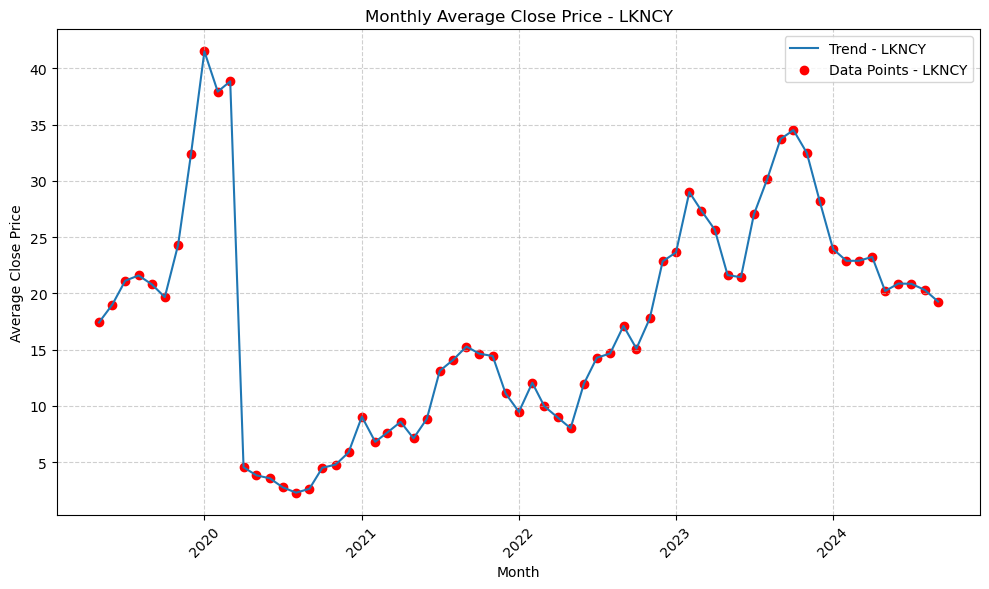

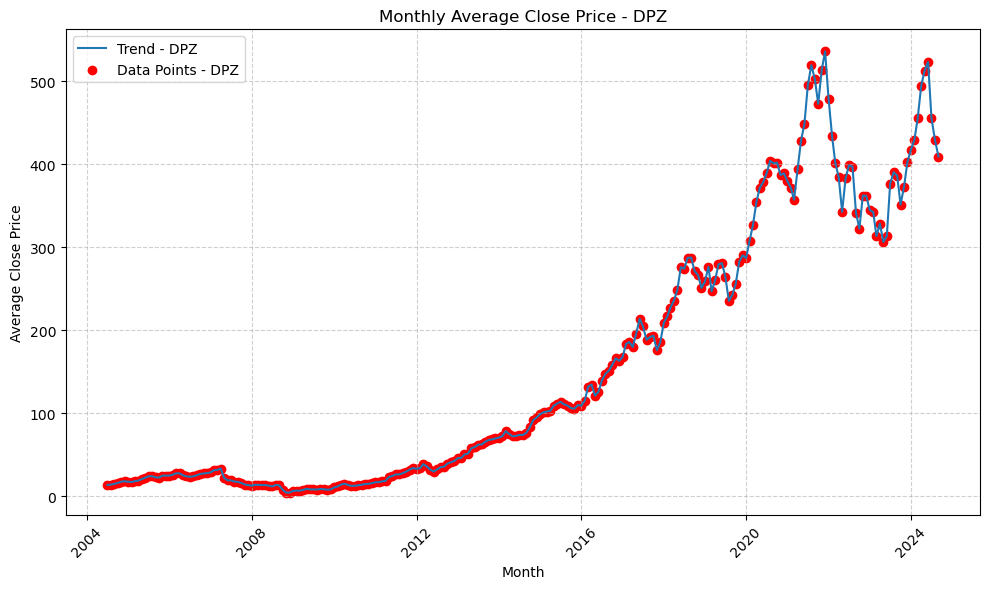

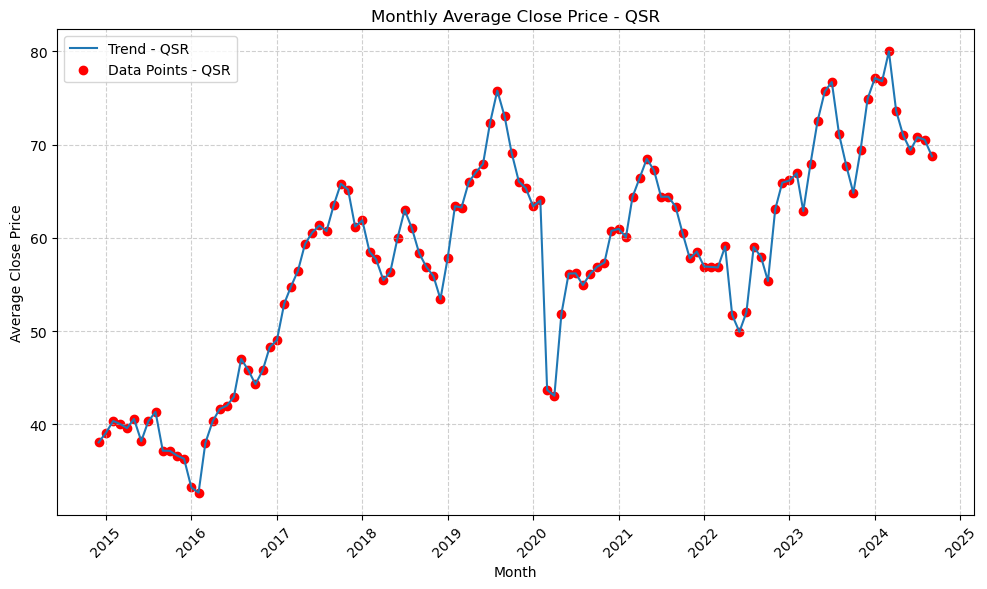

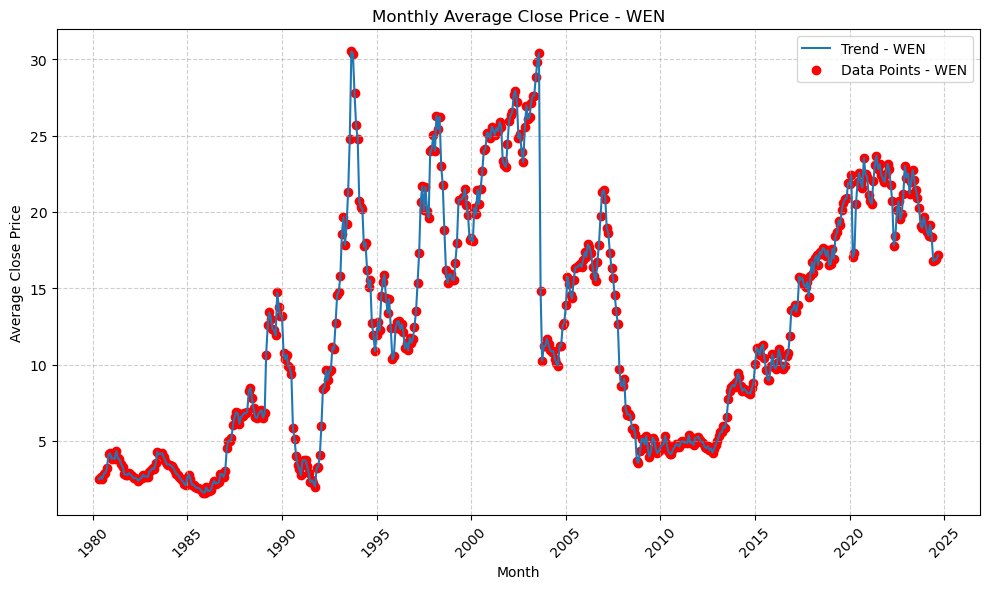

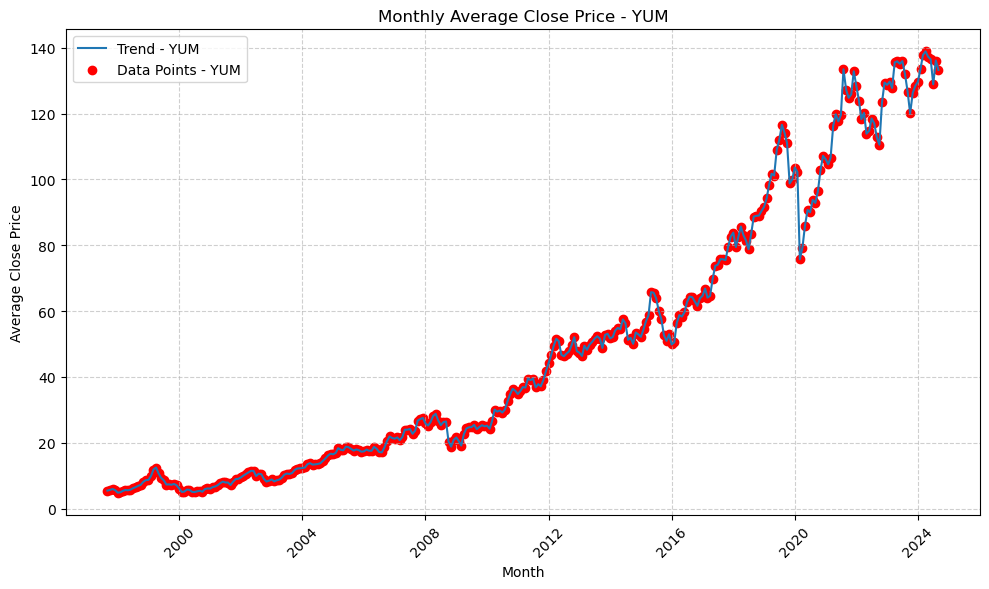

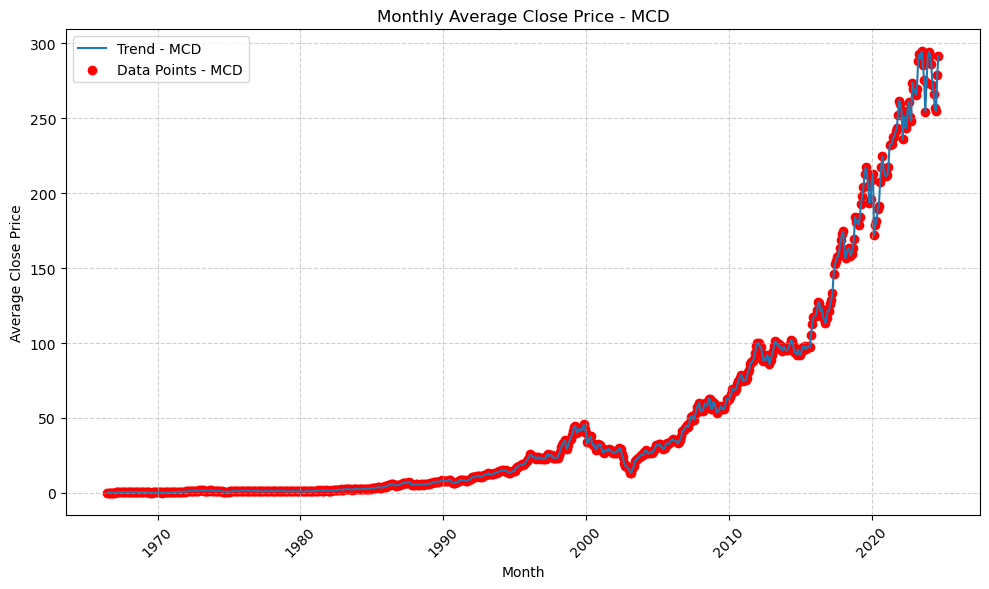

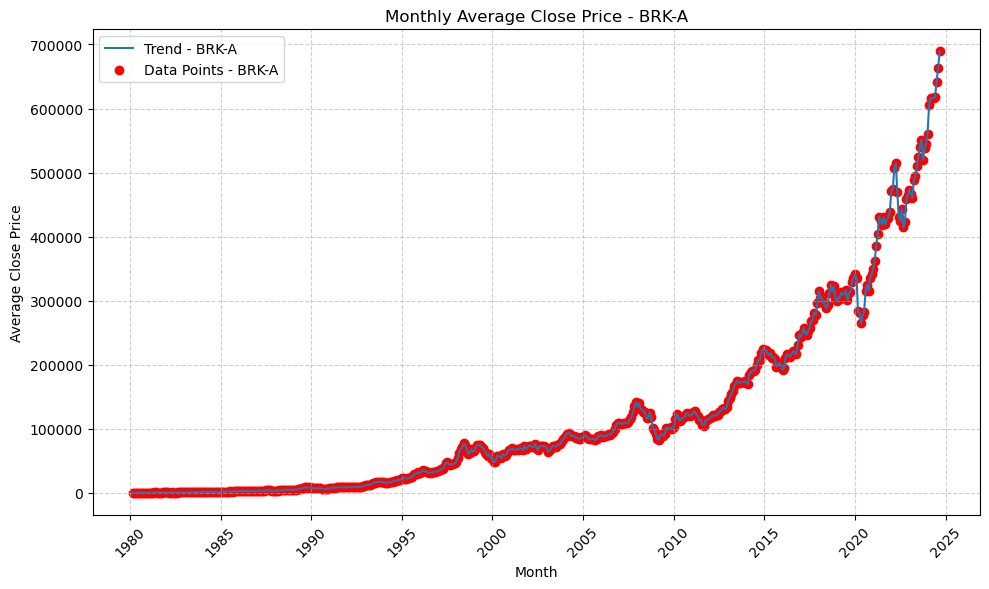

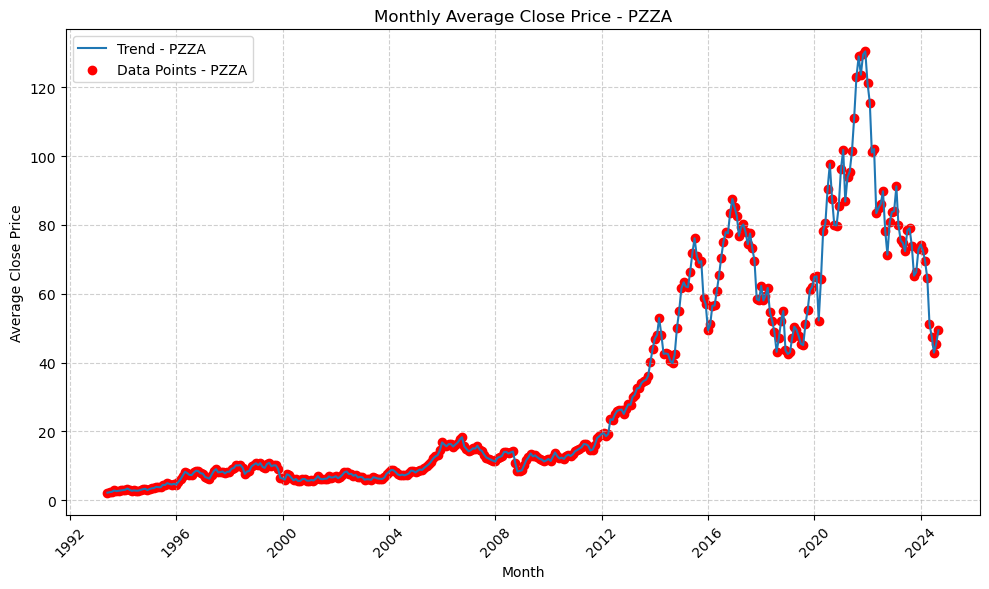

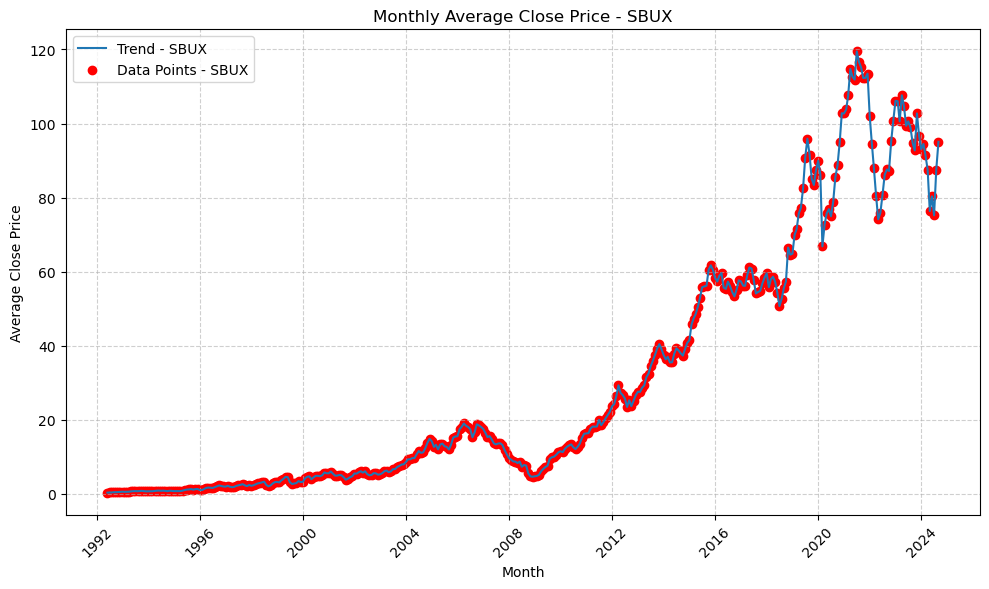

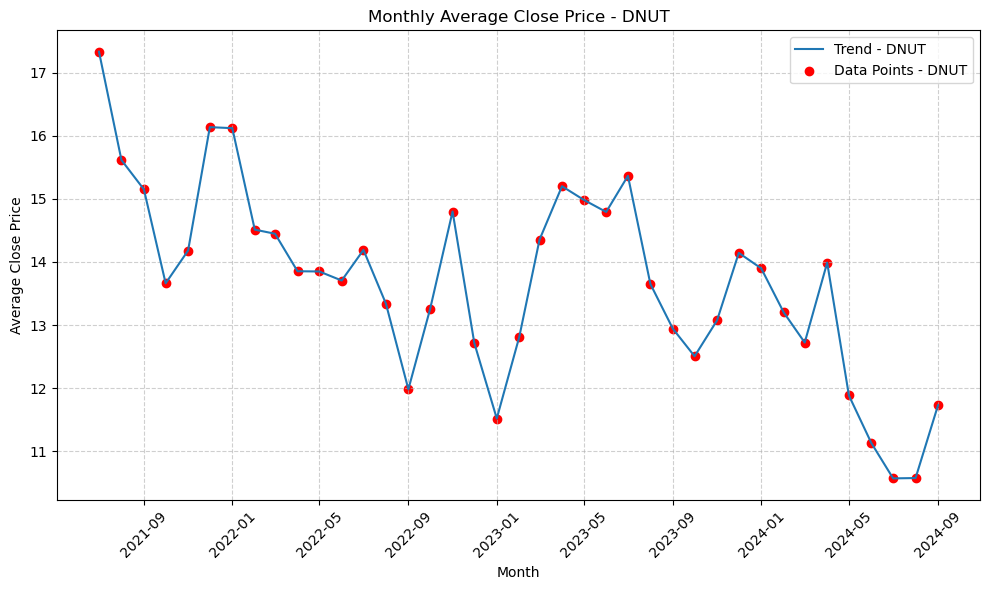

In [1138]:
import matplotlib.pyplot as plt
import pandas as pd

# Create separate enhanced charts for each company
for df in monthly_averages:
    # Ensure YearMonth is in datetime format
    df['YearMonth'] = pd.to_datetime(df['YearMonth'].astype(str))
    
    # Plot line and scatter
    plt.figure(figsize=(10, 6))
    plt.plot(df['YearMonth'], df['Close'], linestyle='-', label=f"Trend - {df['Company'].iloc[0]}")
    plt.scatter(df['YearMonth'], df['Close'], color='red', label=f"Data Points - {df['Company'].iloc[0]}")
    
    # Add chart details
    plt.title(f"Monthly Average Close Price - {df['Company'].iloc[0]}")
    plt.xlabel("Month")
    plt.ylabel("Average Close Price")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### 5. For each company:
- Compute the yearly average of the `Close` price.
- Plot a comparison of yearly averages for all companies on a chart.
- Justify your chart selection.

### 6. For each company, create a plot showing the range of prices for each month.
- Justify the chart selection.


### 7. Create a plot showing the relationship between trading volume and the `Close` price for a selected company.
- Add insights about the pattern and justify your chart selection.


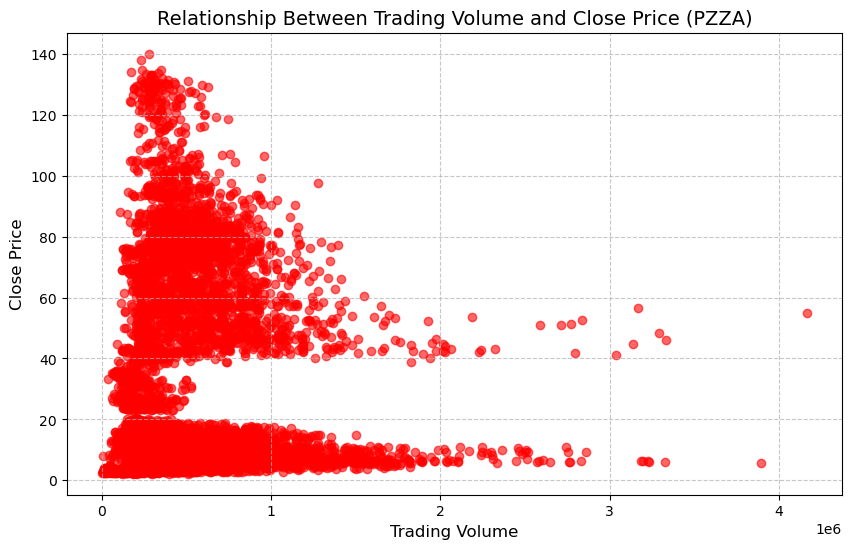

In [1139]:
# Find the DataFrame for the company "PZZA"
pzza_data = [df for df in dataframes if df['Company'].iloc[0] == 'PZZA'][0]  # Filter by company name

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pzza_data['Volume'], pzza_data['Close'], alpha=0.6, color='red')
plt.title('Relationship Between Trading Volume and Close Price (PZZA)', fontsize=14)
plt.xlabel('Trading Volume', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

#### Insights about the pattern :- 

1. **Relationship Observation:**

    - The scatter plot reveals a non linear pattern and most data points are clustered at lower trading values (close to 0) and lower Close Prices (under 100), indicating that low trading activity is common for PZZA. 

2. **Distinct Clusters:**

    - There are horizontal clusters in the data such as around Close Prices of 20, 60 and 100, suggesting that these prices levels may be recurring or significant for the company. 

3. **Spare High Volume Activity:**

    - Trading volumes exceeding 2.5 million are rare and such instances occur accross a broad range of Close Prices. 


#### Justification for Chart Selection:

1. **Shows Relationships Carefully:**

    -  A scatter plot is the best choice for visualizing the relationship between two continuous variables—Trading Volume and Close Price—allowing us to observe patterns, clusters, and outliers effectively.
    
2.  **Highlights Trends and Anomalies:** 

    - It enables easy identification of trends and outliers which are critical for analysis.

3.  **Avoids Misrepresentation:**

    -  Other charts, like bar or line plots, would not work well since the data does not follow a time sequence or a category-based structure. 



### 8. For each company, identify the month with the highest total trading volume.
- Display the results in a summary table, showing the month and total volume.

In [1140]:
# Dictionary to store results
results = {"Company": [], "Highest Volume Month": [], "Total Volume": []}

for df in dataframes:
    # Extract the company name
    company_name = df["Company"].iloc[0]

    # Group by 'Month' and calculate total volume
    monthly_volume = df.groupby("Month")["Volume"].sum()

    # Find the month with the highest trading volume
    max_volume_month = monthly_volume.idxmax()
    max_volume = monthly_volume[max_volume_month]

    # Append to results dictionary
    results["Company"].append(company_name)
    results["Highest Volume Month"].append(max_volume_month)
    results["Total Volume"].append(round(max_volume / 1e6, 2))  # Convert to millions and round

# Convert the results dictionary to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df.to_string(index=False))


KeyError: 'Month'

### 9. Merge the datasets for all companies into a single dataset, one for each year.
- Print the structure of the combined dataset.
- Ensure proper alignment and handling of missing values.


### 10. For each company:
- Calculate the spread between the `High` and `Low` prices for each day.
- Calculate the average spread for each company and visualize the result in a chart.
- Justify the chart selection.
- Identify which companies exhibit the largest spreads and provide insights into their values.
